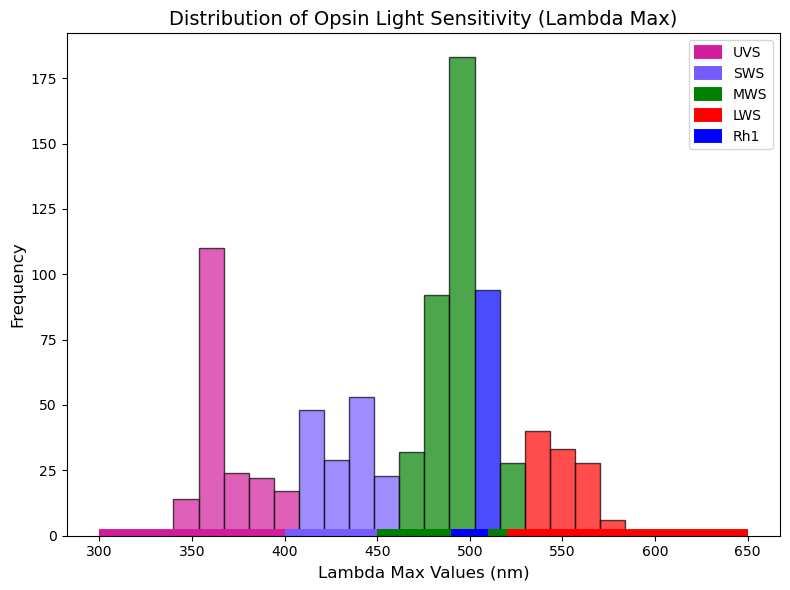

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Sample lambda max values (replace with your actual data)
lambda_max_values = [497.9,503.8,498,499.4,500,501.5,491.5,494.5,483,498,499,497.5,501,495,495.5,498.5,493,499.5,498,489,502,491,498,479,488,486,482,482,497,526,501,507,484,504,490,489,478,511,503,488,491,492,490,501,504,495,488,501,488,499,498,494,501,490,502,494,486,488,485,496,483,526,489,492,507,486,491,479,504,501,501,501,501,482,502,501,502,496,485,486,500,500,493,500,498,495,499,492,501,488,487,498,502,500,497,488,501,504,496,500,498,505,500,490,498,502,484,488,501,488,491,503,498,500,491,500,503,502,494,500,491,497,494,493,492,489,507,508,491,504,486,504,487,511,525,483,500,489,495,524,552,489,501,485,489,492,501,499,494,491,501,482,494,488,488,482,482,490,467,496,496,492,496,0,488,481,495,512,511,467,480,452,459,469,496,491,482,492,494,493,492,471,489,467,467,488,505,464,464,463,465,467,465,468,466,470,471,472,501,536,554,562.8,544,463,458,452,465,453,499,500,497,499,508,500,497,501,502,500,501,500,502,502,501,498,499,500,359,355,423,356,358,360,393,359,415,365,414,359,358,420,419,420,489,488,484,501,498,502,465,453,452,458,571,540,538,542,547,561,565,569,542,558,560,561,566,556,550,543,545,543,550,547,548,546,550,543,552,554,551,551,549,463,482,485,452,466,502,510,514,520,512,514,500,492,505,502,502,500,506,502,502,503,511,506,495,467,503,505,508,359,415,443,437,448,441,455,559,561,558,560,571,530,560,553,509,508,509,524,553,545,531,516,532,482,481,359,359,397,397,382,363,405,369,371,389,358,359,435,500,569,352,578,450,440,528,530,516,527,526,528,475,508,535,520,526,533,528,571,562,516,519,516,476,438,408,353,503,358,439,497,492,420,363,388,357,366,380,419,372,419,360,420,361,360,508,505,502,498,414,424,417,434,383,491,492,491,502,489,461,484,377,480,485,486,486,484,481,450,437,446,425,420,430,561,500,499,404,450,486,479,539,502,525,521,509,510,521,513,515,513,496,508,505,498,505,500,494,505,420,360,360,435,431,430,429,430,431,435,439,431,452,516,492,448,516,494,447,517,486,469,516,491,460,519,491,462,517,493,493,516,508,0,512,508,508,510,508,508,516,515,514,516,515,516,516,514,0,513,514,515,469,454,463,462,485,416,452,466,438,408,439,405,448,397,416,443,416,418,416,417,416,417,418,417,417,417,416,419,443,443,442,440,437,441,444,443,442,442,487,484,477,498,453,467,476,488,505,528,519,484,423,368,511,505,502,502,481,494,494,491,486,490,490,499,493,508,508,508,508,509,503,488,491,491,489,505,488,489,474,524,488,499,497,478,495,493,511,491,484,499,361,360,359,360,360,393,359,360,361,362,361,361,361,392,392,398,392,359,377,357,383,357,369,374,374,374,374,375,375,360,393,393,366,360,398,360,360,359,383,410,389,417,421,422,360,361,404,404,408,404,418,355,380,408,385,411,421,422,361,359,394,360,355,359,361,370,359,361,357,360,391,391,360,359,363,361,358,363,363,383,385,423,365,360,360,396,414,414,381,363,405,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,381,363,403,395,412,411,352,369,352,369,498,367,412,416,359,360,411,360,552,558,363,511,431,356,357,442,584,509,572,507,352,359,358,507,511,519,563,563,561,558,558,536,561,564,532,553,532,533,532,554,553,532,534,533,532,501.7,499,359,376,358,358,424,430,354,367,361,431,403,363,403,365,363,539,611,542,557,577,532,532,537,518,500,499,482,482,482,431,443,433,363,370,365,430,353,353,0,415,352,365,371,0,429,425,485,482,494,490,551,539,532,532,533,533,545,545,546,546,558,559,556,559,555,536,550,543,527,533,545,536,525,522,516,534,512,532,439,439,438,438,438,439,438,439,442,438,439,444,448,444,449,448,450,453,430,500,340,430,485,347,486,344,436,434,435,377,434,436,437,434,435,437,420,421,488,345,375,439,353,487.3,380,350,450,513]
lambda_max_values_filtered = [value for value in lambda_max_values if value != 0]
lambda_max_values = lambda_max_values_filtered

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create histogram
n, bins, patches = ax.hist(lambda_max_values, bins=20, color='lightgray', edgecolor='black', alpha=0.7)

# Set up light spectrum bar at the bottom
light_spectrum = {
    'UVS': (300, 400, '#d01d9b'),
    'SWS': (400, 450, '#765bff'),
    'MWS' : (450,480, 'green'),
    ''
    'LWS' : (520,650, 'red'),
   
}

# Update bin colors based on light spectrum
for bin_value, patch in zip(bins, patches):
    for start, end, color in light_spectrum.values():
        if start <= bin_value < end:
            patch.set_facecolor(color)

# Plot light spectrum bar
for region, (start, end, color) in light_spectrum.items():
    ax.plot([start, end], [0, 0], color=color, linewidth=10, solid_capstyle='butt', label=region)

# Customize plot
ax.set_xlabel('Lambda Max Values (nm)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Opsin Light Sensitivity (Lambda Max)', fontsize=14)


# Show the plot with legend
ax.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

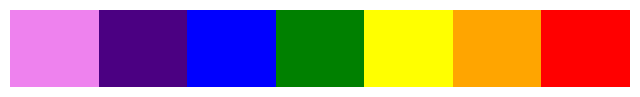

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Wavelength range for the visible spectrum in nanometers
wavelengths = np.arange(380, 751, 1)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 1))

# Create a colormap with the colors of the visible spectrum
colors = ['violet', 'indigo', 'blue', 'green', 'yellow', 'orange', 'red']
cmap = plt.cm.colors.ListedColormap(colors)

# Create an image with a single row and pixels colored according to the wavelength
image = ax.imshow([wavelengths], cmap=cmap, aspect='auto', extent=[380, 750, -1, 1])

# Customize the plot
ax.set_xlim(380, 750)
ax.set_ylim(-1, 1)
ax.axis('off')

# Show the plot
plt.show()

C:\Users\safra\AppData\Local\Temp\ipykernel_23692\4071830846.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('rainbow')


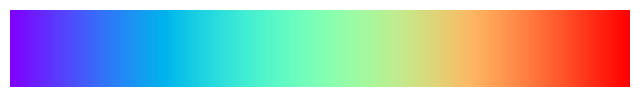

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Wavelength range for the visible spectrum in nanometers
wavelengths = np.arange(380, 751, 1)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 1))

# Create a colormap with a smooth gradient representing the visible spectrum
cmap = plt.cm.get_cmap('rainbow')

# Create an image with a single row and a smooth gradient colormap
image = ax.imshow([wavelengths], cmap=cmap, aspect='auto', extent=[380, 750, -1, 1])

# Customize the plot
ax.set_xlim(380, 750)
ax.set_ylim(-1, 1)
ax.axis('off')

# Show the plot
plt.show()

C:\Users\safra\AppData\Local\Temp\ipykernel_23692\1274394240.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_uv = plt.cm.get_cmap('Blues')
C:\Users\safra\AppData\Local\Temp\ipykernel_23692\1274394240.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_visible = plt.cm.get_cmap('rainbow')
C:\Users\safra\AppData\Local\Temp\ipykernel_23692\1274394240.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_infrared = plt.cm.get_cmap('Reds')


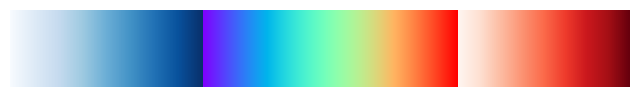

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Wavelength range for the UV, visible, and infrared spectrum in nanometers
wavelengths_uv = np.arange(100, 380, 1)
wavelengths_visible = np.arange(380, 751, 1)
wavelengths_infrared = np.arange(751, 1000, 1)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 1))

# Create colormaps for UV, visible, and infrared
cmap_uv = plt.cm.get_cmap('Blues')
cmap_visible = plt.cm.get_cmap('rainbow')
cmap_infrared = plt.cm.get_cmap('Reds')

# Plot UV spectrum
ax.imshow([wavelengths_uv], cmap=cmap_uv, aspect='auto', extent=[100, 380, -1, 1])

# Plot visible spectrum
ax.imshow([wavelengths_visible], cmap=cmap_visible, aspect='auto', extent=[380, 750, -1, 1])

# Plot infrared spectrum
ax.imshow([wavelengths_infrared], cmap=cmap_infrared, aspect='auto', extent=[751, 1000, -1, 1])

# Customize the plot
ax.set_xlim(100, 1000)
ax.set_ylim(-1, 1)
ax.axis('off')

# Show the plot
plt.show()

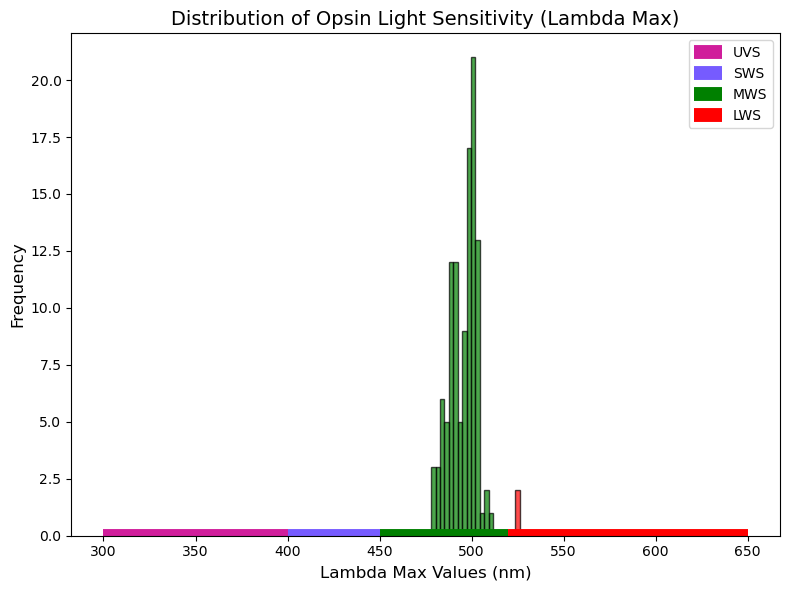

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Sample lambda max values (replace with your actual data)
lambda_max_values = [497.9, 503.8, 498, 499.4, 500, 501.5, 491.5, 494.5, 483, 498, 499, 497.5, 501, 495, 495.5, 498.5,
                      493, 499.5, 498, 489, 502, 491, 498, 479, 488, 486, 482, 482, 497, 526, 501, 507, 484, 504, 490, 
                      489, 478, 511, 503, 488, 491, 492, 490, 501, 504, 495, 488, 501, 488, 499, 498, 494, 501, 490, 
                      502, 494, 486, 488, 485, 496, 483, 526, 489, 492, 507, 486, 491, 479, 504, 501, 501, 501, 501, 
                      482, 502, 501, 502, 496, 485, 486, 500, 500, 493, 500, 498, 495, 499, 492, 501, 488, 487, 498, 
                      502, 500, 497, 488, 501, 504, 496, 500, 498, 505, 500, 490, 498, 502, 484, 488, 501, 488, 491, 
                      503]

lambda_max_values_filtered = [value for value in lambda_max_values if value != 0]
lambda_max_values = lambda_max_values_filtered

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create histogram
n, bins, patches = ax.hist(lambda_max_values, bins=20, color='lightgray', edgecolor='black', alpha=0.7)

# Set up light spectrum bar at the bottom
light_spectrum = {
    'UVS': (300, 400, '#d01d9b'),
    'SWS': (400, 450, '#765bff'),
    'MWS': (450, 520, 'green'),
    'LWS': (520, 650, 'red'),
}

# Update bin colors based on light spectrum
for bin_value, patch in zip(bins, patches):
    for start, end, color in light_spectrum.values():
        if start <= bin_value < end:
            patch.set_facecolor(color)

# Plot light spectrum bar
for region, (start, end, color) in light_spectrum.items():
    ax.plot([start, end], [0, 0], color=color, linewidth=10, solid_capstyle='butt', label=region)

# Customize plot
ax.set_xlabel('Lambda Max Values (nm)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Opsin Light Sensitivity (Lambda Max)', fontsize=14)

# Show the plot with legend
ax.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

C:\Users\safra\AppData\Local\Temp\ipykernel_35548\3794686361.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('rainbow')


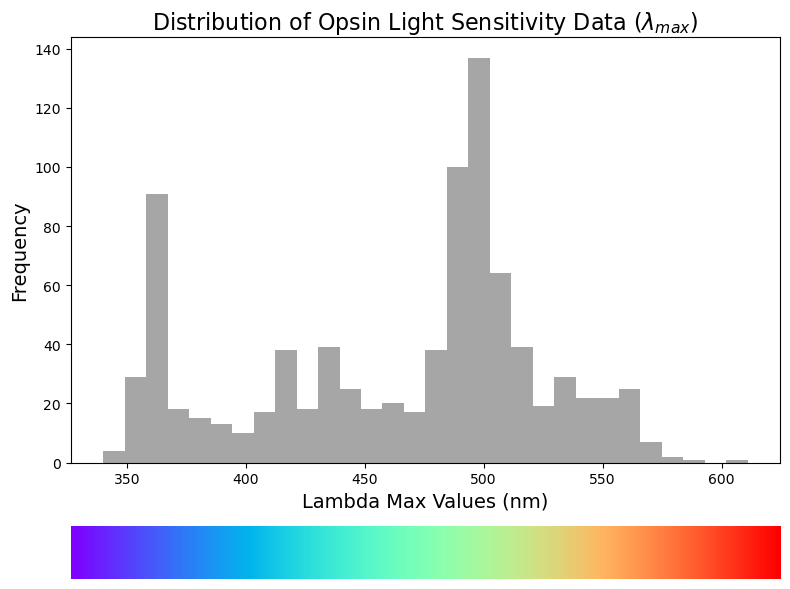

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Sample lambda max values (replace with your actual data)
lambda_max_values = [497.9,503.8,498,499.4,500,501.5,491.5,494.5,483,498,499,497.5,501,495,495.5,498.5,493,499.5,498,489,502,491,498,479,488,486,482,482,497,526,501,507,484,504,490,489,478,511,503,488,491,492,490,501,504,495,488,501,488,499,498,494,501,490,502,494,486,488,485,496,483,526,489,492,507,486,491,479,504,501,501,501,501,482,502,501,502,496,485,486,500,500,493,500,498,495,499,492,501,488,487,498,502,500,497,488,501,504,496,500,498,505,500,490,498,502,484,488,501,488,491,503,498,500,491,500,503,502,494,500,491,497,494,493,492,489,507,508,491,504,486,504,487,511,525,483,500,489,495,524,552,489,501,485,489,492,501,499,494,491,501,482,494,488,488,482,482,490,467,496,496,492,496,0,488,481,495,512,511,467,480,452,459,469,496,491,482,492,494,493,492,471,489,467,467,488,505,464,464,463,465,467,465,468,466,470,471,472,501,536,554,562.8,544,463,458,452,465,453,499,500,497,499,508,500,497,501,502,500,501,500,502,502,501,498,499,500,359,355,423,356,358,360,393,359,415,365,414,359,358,420,419,420,489,488,484,501,498,502,465,453,452,458,571,540,538,542,547,561,565,569,542,558,560,561,566,556,550,543,545,543,550,547,548,546,550,543,552,554,551,551,549,463,482,485,452,466,502,510,514,520,512,514,500,492,505,502,502,500,506,502,502,503,511,506,495,467,503,505,508,359,415,443,437,448,441,455,559,561,558,560,571,530,560,553,509,508,509,524,553,545,531,516,532,482,481,359,359,397,397,382,363,405,369,371,389,358,359,435,500,569,352,578,450,440,528,530,516,527,526,528,475,508,535,520,526,533,528,571,562,516,519,516,476,438,408,353,503,358,439,497,492,420,363,388,357,366,380,419,372,419,360,420,361,360,508,505,502,498,414,424,417,434,383,491,492,491,502,489,461,484,377,480,485,486,486,484,481,450,437,446,425,420,430,561,500,499,404,450,486,479,539,502,525,521,509,510,521,513,515,513,496,508,505,498,505,500,494,505,420,360,360,435,431,430,429,430,431,435,439,431,452,516,492,448,516,494,447,517,486,469,516,491,460,519,491,462,517,493,493,516,508,0,512,508,508,510,508,508,516,515,514,516,515,516,516,514,0,513,514,515,469,454,463,462,485,416,452,466,438,408,439,405,448,397,416,443,416,418,416,417,416,417,418,417,417,417,416,419,443,443,442,440,437,441,444,443,442,442,487,484,477,498,453,467,476,488,505,528,519,484,423,368,511,505,502,502,481,494,494,491,486,490,490,499,493,508,508,508,508,509,503,488,491,491,489,505,488,489,474,524,488,499,497,478,495,493,511,491,484,499,361,360,359,360,360,393,359,360,361,362,361,361,361,392,392,398,392,359,377,357,383,357,369,374,374,374,374,375,375,360,393,393,366,360,398,360,360,359,383,410,389,417,421,422,360,361,404,404,408,404,418,355,380,408,385,411,421,422,361,359,394,360,355,359,361,370,359,361,357,360,391,391,360,359,363,361,358,363,363,383,385,423,365,360,360,396,414,414,381,363,405,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,381,363,403,395,412,411,352,369,352,369,498,367,412,416,359,360,411,360,552,558,363,511,431,356,357,442,584,509,572,507,352,359,358,507,511,519,563,563,561,558,558,536,561,564,532,553,532,533,532,554,553,532,534,533,532,501.7,499,359,376,358,358,424,430,354,367,361,431,403,363,403,365,363,539,611,542,557,577,532,532,537,518,500,499,482,482,482,431,443,433,363,370,365,430,353,353,0,415,352,365,371,0,429,425,485,482,494,490,551,539,532,532,533,533,545,545,546,546,558,559,556,559,555,536,550,543,527,533,545,536,525,522,516,534,512,532,439,439,438,438,438,439,438,439,442,438,439,444,448,444,449,448,450,453,430,500,340,430,485,347,486,344,436,434,435,377,434,436,437,434,435,437,420,421,488,345,375,439,353,487.3,380,350,450,513]
lambda_max_values_filtered = [value for value in lambda_max_values if value != 0]
lambda_max_values = lambda_max_values_filtered

# Create figure and axis
fig, axs = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [8, 1]})

# Histogram subplot
axs[0].hist(lambda_max_values, bins=30, color='gray', edgecolor='none', alpha=0.7)

# Customize plot
axs[0].set_xlabel('Lambda Max Values (nm)', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[0].set_title('Distribution of Opsin Light Sensitivity Data ($\lambda_{max}$)', fontsize=16)

# Color bar subplot
# Wavelength range for the visible spectrum in nanometers
wavelengths = np.arange(380, 751, 1)

# Create a colormap with a smooth gradient representing the visible spectrum
cmap = plt.cm.get_cmap('rainbow')

# Create an image with a single row and a smooth gradient colormap
image = axs[1].imshow([wavelengths], cmap=cmap, aspect='auto', extent=[380, 750, -1, 1])

# Customize the plot
axs[1].set_xlim(380, 750)
axs[1].set_ylim(-1, 1)
axs[1].axis('off')

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('opsin_light_sensitivity.png', dpi=300)
plt.show()

C:\Users\safra\AppData\Local\Temp\ipykernel_22360\855735126.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('rainbow')


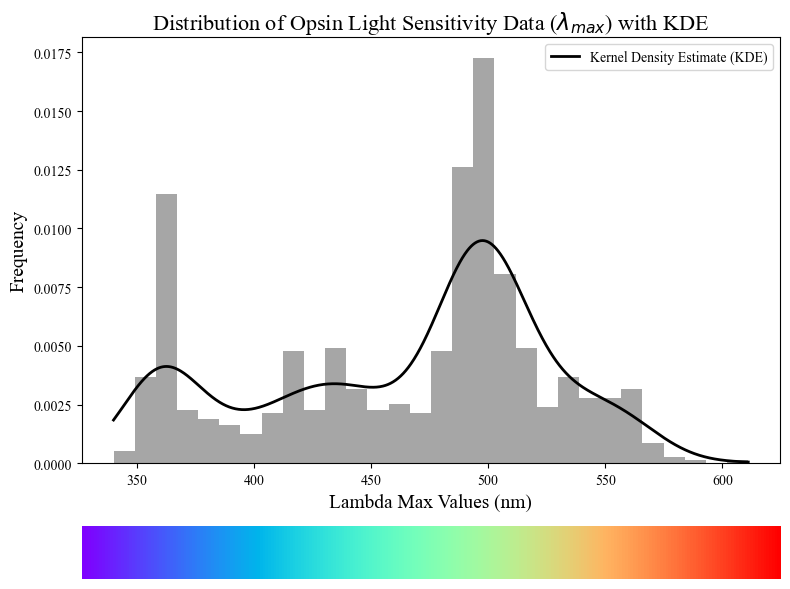

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

plt.rcParams["font.family"] = "times new roman"

# Sample lambda max values (replace with your actual data)
lambda_max_values = [497.9,503.8,498,499.4,500,501.5,491.5,494.5,483,498,499,497.5,501,495,495.5,498.5,493,499.5,498,489,502,491,498,479,488,486,482,482,497,526,501,507,484,504,490,489,478,511,503,488,491,492,490,501,504,495,488,501,488,499,498,494,501,490,502,494,486,488,485,496,483,526,489,492,507,486,491,479,504,501,501,501,501,482,502,501,502,496,485,486,500,500,493,500,498,495,499,492,501,488,487,498,502,500,497,488,501,504,496,500,498,505,500,490,498,502,484,488,501,488,491,503,498,500,491,500,503,502,494,500,491,497,494,493,492,489,507,508,491,504,486,504,487,511,525,483,500,489,495,524,552,489,501,485,489,492,501,499,494,491,501,482,494,488,488,482,482,490,467,496,496,492,496,0,488,481,495,512,511,467,480,452,459,469,496,491,482,492,494,493,492,471,489,467,467,488,505,464,464,463,465,467,465,468,466,470,471,472,501,536,554,562.8,544,463,458,452,465,453,499,500,497,499,508,500,497,501,502,500,501,500,502,502,501,498,499,500,359,355,423,356,358,360,393,359,415,365,414,359,358,420,419,420,489,488,484,501,498,502,465,453,452,458,571,540,538,542,547,561,565,569,542,558,560,561,566,556,550,543,545,543,550,547,548,546,550,543,552,554,551,551,549,463,482,485,452,466,502,510,514,520,512,514,500,492,505,502,502,500,506,502,502,503,511,506,495,467,503,505,508,359,415,443,437,448,441,455,559,561,558,560,571,530,560,553,509,508,509,524,553,545,531,516,532,482,481,359,359,397,397,382,363,405,369,371,389,358,359,435,500,569,352,578,450,440,528,530,516,527,526,528,475,508,535,520,526,533,528,571,562,516,519,516,476,438,408,353,503,358,439,497,492,420,363,388,357,366,380,419,372,419,360,420,361,360,508,505,502,498,414,424,417,434,383,491,492,491,502,489,461,484,377,480,485,486,486,484,481,450,437,446,425,420,430,561,500,499,404,450,486,479,539,502,525,521,509,510,521,513,515,513,496,508,505,498,505,500,494,505,420,360,360,435,431,430,429,430,431,435,439,431,452,516,492,448,516,494,447,517,486,469,516,491,460,519,491,462,517,493,493,516,508,0,512,508,508,510,508,508,516,515,514,516,515,516,516,514,0,513,514,515,469,454,463,462,485,416,452,466,438,408,439,405,448,397,416,443,416,418,416,417,416,417,418,417,417,417,416,419,443,443,442,440,437,441,444,443,442,442,487,484,477,498,453,467,476,488,505,528,519,484,423,368,511,505,502,502,481,494,494,491,486,490,490,499,493,508,508,508,508,509,503,488,491,491,489,505,488,489,474,524,488,499,497,478,495,493,511,491,484,499,361,360,359,360,360,393,359,360,361,362,361,361,361,392,392,398,392,359,377,357,383,357,369,374,374,374,374,375,375,360,393,393,366,360,398,360,360,359,383,410,389,417,421,422,360,361,404,404,408,404,418,355,380,408,385,411,421,422,361,359,394,360,355,359,361,370,359,361,357,360,391,391,360,359,363,361,358,363,363,383,385,423,365,360,360,396,414,414,381,363,405,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,381,363,403,395,412,411,352,369,352,369,498,367,412,416,359,360,411,360,552,558,363,511,431,356,357,442,584,509,572,507,352,359,358,507,511,519,563,563,561,558,558,536,561,564,532,553,532,533,532,554,553,532,534,533,532,501.7,499,359,376,358,358,424,430,354,367,361,431,403,363,403,365,363,539,611,542,557,577,532,532,537,518,500,499,482,482,482,431,443,433,363,370,365,430,353,353,0,415,352,365,371,0,429,425,485,482,494,490,551,539,532,532,533,533,545,545,546,546,558,559,556,559,555,536,550,543,527,533,545,536,525,522,516,534,512,532,439,439,438,438,438,439,438,439,442,438,439,444,448,444,449,448,450,453,430,500,340,430,485,347,486,344,436,434,435,377,434,436,437,434,435,437,420,421,488,345,375,439,353,487.3,380,350,450,513]
lambda_max_values_filtered = [value for value in lambda_max_values if value != 0]
lambda_max_values = lambda_max_values_filtered

# Create figure and axis
fig, axs = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [8, 1]})
# Histogram subplot
n, bins, patches = axs[0].hist(lambda_max_values, bins=30, color='gray', edgecolor='none', alpha=0.7, density=True)

# Overlay KDE curve
kde = gaussian_kde(lambda_max_values)
x_vals = np.linspace(min(lambda_max_values), max(lambda_max_values), 1000)
y_vals = kde(x_vals)
axs[0].plot(x_vals, y_vals, color='black', linewidth=2, label='Kernel Density Estimate (KDE)')

# Customize plot
axs[0].set_xlabel('Lambda Max Values (nm)', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[0].set_title('Distribution of Opsin Light Sensitivity Data ($\lambda_{max}$) with KDE', fontsize=16)
axs[0].legend()

# Color bar subplot
# Wavelength range for the visible spectrum in nanometers
wavelengths = np.arange(380, 751, 1)

# Create a colormap with a smooth gradient representing the visible spectrum
cmap = plt.cm.get_cmap('rainbow')

# Create an image with a single row and a smooth gradient colormap
image = axs[1].imshow([wavelengths], cmap=cmap, aspect='auto', extent=[380, 750, -1, 1])

# Customize the plot
axs[1].set_xlim(380, 750)
axs[1].set_ylim(-1, 1)
axs[1].axis('off')

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('opsin_light_sensitivity_with_kde.png', dpi=300)
plt.show()

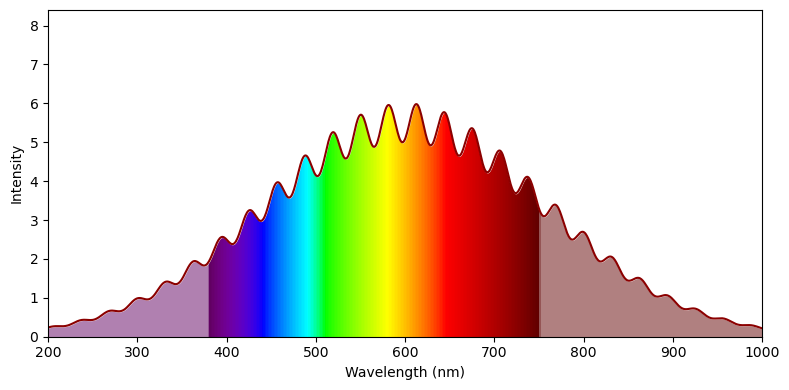

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors


def wavelength_to_rgb(wavelength, gamma=0.8):
    ''' taken from http://www.noah.org/wiki/Wavelength_to_RGB_in_Python
    This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 750:
        A = 1.
    else:
        A=0.5
    if wavelength < 380:
        wavelength = 380.
    if wavelength >750:
        wavelength = 750.
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    return (R,G,B,A)

clim=(350,780)
norm = plt.Normalize(*clim)
wl = np.arange(clim[0],clim[1]+1,2)
colorlist = list(zip(norm(wl),[wavelength_to_rgb(w) for w in wl]))
spectralmap = matplotlib.colors.LinearSegmentedColormap.from_list("spectrum", colorlist)

fig, axs = plt.subplots(1, 1, figsize=(8,4), tight_layout=True)

wavelengths = np.linspace(200, 1000, 1000)
spectrum = (5 + np.sin(wavelengths*0.1)**2) * np.exp(-0.00002*(wavelengths-600)**2)
plt.plot(wavelengths, spectrum, color='darkred')

y = np.linspace(0, 6, 100)
X,Y = np.meshgrid(wavelengths, y)

extent=(np.min(wavelengths), np.max(wavelengths), np.min(y), np.max(y))

plt.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect='auto')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')

plt.fill_between(wavelengths, spectrum, 8, color='w')
plt.savefig('WavelengthColors.png', dpi=200)


plt.show()

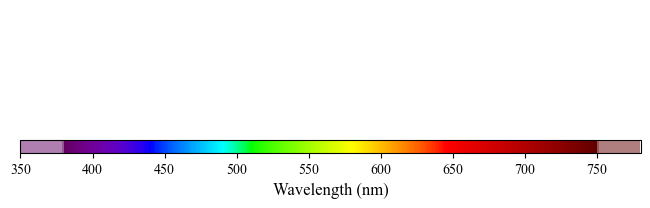

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

def wavelength_to_rgb(wavelength, gamma=0.8):
    ''' taken from http://www.noah.org/wiki/Wavelength_to_RGB_in_Python
    This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 750:
        A = 1.
    else:
        A=0.5
    if wavelength < 380:
        wavelength = 380.
    if wavelength >750:
        wavelength = 750.
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    return (R,G,B,A)


# Create a colormap with a smooth gradient representing the visible spectrum
def create_spectrum_colormap(clim=(350, 780), gamma=0.8):
    norm = plt.Normalize(*clim)
    wl = np.arange(clim[0], clim[1] + 1, 2)
    colorlist = [wavelength_to_rgb(w, gamma) for w in wl]
    spectralmap = matplotlib.colors.LinearSegmentedColormap.from_list("spectrum", colorlist)
    return spectralmap

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 2))

# Create a colormap representing the visible spectrum
spectrum_colormap = create_spectrum_colormap()

# Wavelength range for the color bar in nanometers
wavelengths_colorbar = np.linspace(350, 780, 1000)


# Customize the color bar plot
ax.set_xlim(350, 780)
ax.set_ylim(0, 1)
ax.axis('off')

# Add color bar
cbar = plt.colorbar(image, ax=ax, orientation='horizontal', pad=0.04, aspect=50)
cbar.set_label('Wavelength (nm)', fontsize=12)

# Save the color bar plot
plt.savefig('colorbar_spectrum.png', dpi=300)
plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

def wavelength_to_rgb(wavelength, gamma=0.8):
    ''' taken from http://www.noah.org/wiki/Wavelength_to_RGB_in_Python
    This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 750:
        A = 1.
    else:
        A=0.5
    if wavelength < 380:
        wavelength = 380.
    if wavelength >750:
        wavelength = 750.
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    return (R,G,B,A)

def create_spectrum_colormap(clim=(350, 780), gamma=0.8):
    norm = plt.Normalize(*clim)
    wl = np.arange(clim[0], clim[1] + 1, 2)
    colorlist = [wavelength_to_rgb(w, gamma) for w in wl]
    spectralmap = matplotlib.colors.LinearSegmentedColormap.from_list("spectrum", colorlist)
    return spectralmap


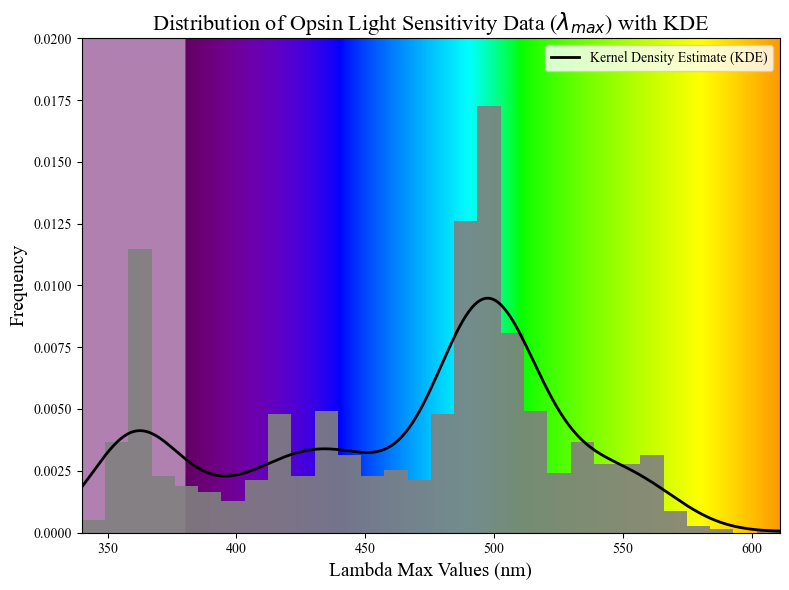

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

#Adding in out desired font - feel free to change. :)
gothic_font = fm.FontProperties(fname='C:/Windows/Fonts/Gothic.ttf')
plt.rcParams['font.family'] = gothic_font.get_name()

# Sample lambda max values (replace with your actual data)
lambda_max_values = [497.9,503.8,498,499.4,500,501.5,491.5,494.5,483,498,499,497.5,501,495,495.5,498.5,493,499.5,498,489,502,491,498,479,488,486,482,482,497,526,501,507,484,504,490,489,478,511,503,488,491,492,490,501,504,495,488,501,488,499,498,494,501,490,502,494,486,488,485,496,483,526,489,492,507,486,491,479,504,501,501,501,501,482,502,501,502,496,485,486,500,500,493,500,498,495,499,492,501,488,487,498,502,500,497,488,501,504,496,500,498,505,500,490,498,502,484,488,501,488,491,503,498,500,491,500,503,502,494,500,491,497,494,493,492,489,507,508,491,504,486,504,487,511,525,483,500,489,495,524,552,489,501,485,489,492,501,499,494,491,501,482,494,488,488,482,482,490,467,496,496,492,496,0,488,481,495,512,511,467,480,452,459,469,496,491,482,492,494,493,492,471,489,467,467,488,505,464,464,463,465,467,465,468,466,470,471,472,501,536,554,562.8,544,463,458,452,465,453,499,500,497,499,508,500,497,501,502,500,501,500,502,502,501,498,499,500,359,355,423,356,358,360,393,359,415,365,414,359,358,420,419,420,489,488,484,501,498,502,465,453,452,458,571,540,538,542,547,561,565,569,542,558,560,561,566,556,550,543,545,543,550,547,548,546,550,543,552,554,551,551,549,463,482,485,452,466,502,510,514,520,512,514,500,492,505,502,502,500,506,502,502,503,511,506,495,467,503,505,508,359,415,443,437,448,441,455,559,561,558,560,571,530,560,553,509,508,509,524,553,545,531,516,532,482,481,359,359,397,397,382,363,405,369,371,389,358,359,435,500,569,352,578,450,440,528,530,516,527,526,528,475,508,535,520,526,533,528,571,562,516,519,516,476,438,408,353,503,358,439,497,492,420,363,388,357,366,380,419,372,419,360,420,361,360,508,505,502,498,414,424,417,434,383,491,492,491,502,489,461,484,377,480,485,486,486,484,481,450,437,446,425,420,430,561,500,499,404,450,486,479,539,502,525,521,509,510,521,513,515,513,496,508,505,498,505,500,494,505,420,360,360,435,431,430,429,430,431,435,439,431,452,516,492,448,516,494,447,517,486,469,516,491,460,519,491,462,517,493,493,516,508,0,512,508,508,510,508,508,516,515,514,516,515,516,516,514,0,513,514,515,469,454,463,462,485,416,452,466,438,408,439,405,448,397,416,443,416,418,416,417,416,417,418,417,417,417,416,419,443,443,442,440,437,441,444,443,442,442,487,484,477,498,453,467,476,488,505,528,519,484,423,368,511,505,502,502,481,494,494,491,486,490,490,499,493,508,508,508,508,509,503,488,491,491,489,505,488,489,474,524,488,499,497,478,495,493,511,491,484,499,361,360,359,360,360,393,359,360,361,362,361,361,361,392,392,398,392,359,377,357,383,357,369,374,374,374,374,375,375,360,393,393,366,360,398,360,360,359,383,410,389,417,421,422,360,361,404,404,408,404,418,355,380,408,385,411,421,422,361,359,394,360,355,359,361,370,359,361,357,360,391,391,360,359,363,361,358,363,363,383,385,423,365,360,360,396,414,414,381,363,405,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,381,363,403,395,412,411,352,369,352,369,498,367,412,416,359,360,411,360,552,558,363,511,431,356,357,442,584,509,572,507,352,359,358,507,511,519,563,563,561,558,558,536,561,564,532,553,532,533,532,554,553,532,534,533,532,501.7,499,359,376,358,358,424,430,354,367,361,431,403,363,403,365,363,539,611,542,557,577,532,532,537,518,500,499,482,482,482,431,443,433,363,370,365,430,353,353,0,415,352,365,371,0,429,425,485,482,494,490,551,539,532,532,533,533,545,545,546,546,558,559,556,559,555,536,550,543,527,533,545,536,525,522,516,534,512,532,439,439,438,438,438,439,438,439,442,438,439,444,448,444,449,448,450,453,430,500,340,430,485,347,486,344,436,434,435,377,434,436,437,434,435,437,420,421,488,345,375,439,353,487.3,380,350,450,513]
lambda_max_values_filtered = [value for value in lambda_max_values if value != 0]
lambda_max_values = lambda_max_values_filtered

# Create figure and axes for the histogram
fig, ax_hist = plt.subplots(figsize=(8, 6))

# Wavelength range for the color background in nanometers
wavelengths_background = np.linspace(min(lambda_max_values), max(lambda_max_values), 1000)

# Create an image with a single row and a smooth gradient colormap as background
background_colors = [wavelength_to_rgb(w) for w in wavelengths_background]
ax_hist.imshow([background_colors], aspect='auto', extent=[min(lambda_max_values), max(lambda_max_values), 0, 0.020])

# Histogram subplot
n, bins, patches = ax_hist.hist(lambda_max_values, bins=30, color='gray', edgecolor='none', alpha=0.9, density=True)

# Overlay KDE curve
kde = gaussian_kde(lambda_max_values)
x_vals = np.linspace(min(lambda_max_values), max(lambda_max_values), 1000)
y_vals = kde(x_vals)
ax_hist.plot(x_vals, y_vals, color='black', linewidth=2, label='Kernel Density Estimate (KDE)')

# Customize histogram plot
ax_hist.set_xlabel('Lambda Max Values (nm)', fontsize=14)
ax_hist.set_ylabel('Frequency', fontsize=14)
ax_hist.set_title('Distribution of Opsin Light Sensitivity Data ($\lambda_{max}$) with KDE', fontsize=16)
ax_hist.legend()

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('histogram_with_kde_and_gradient_background.png', dpi=300)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

def wavelength_to_rgb(wavelength, gamma=0.8):
    ''' taken from http://www.noah.org/wiki/Wavelength_to_RGB_in_Python
    This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 750:
        A = 1.
    else:
        A=0.5
    if wavelength < 380:
        wavelength = 380.
    if wavelength >750:
        wavelength = 750.
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    return (R,G,B,A)


# Create a colormap with a smooth gradient representing the visible spectrum
def create_spectrum_colormap(clim=(350, 780), gamma=0.8):
    norm = plt.Normalize(*clim)
    wl = np.arange(clim[0], clim[1] + 1, 2)
    colorlist = [wavelength_to_rgb(w, gamma) for w in wl]
    spectralmap = matplotlib.colors.LinearSegmentedColormap.from_list("spectrum", colorlist)
    return spectralmap

Century Gothic


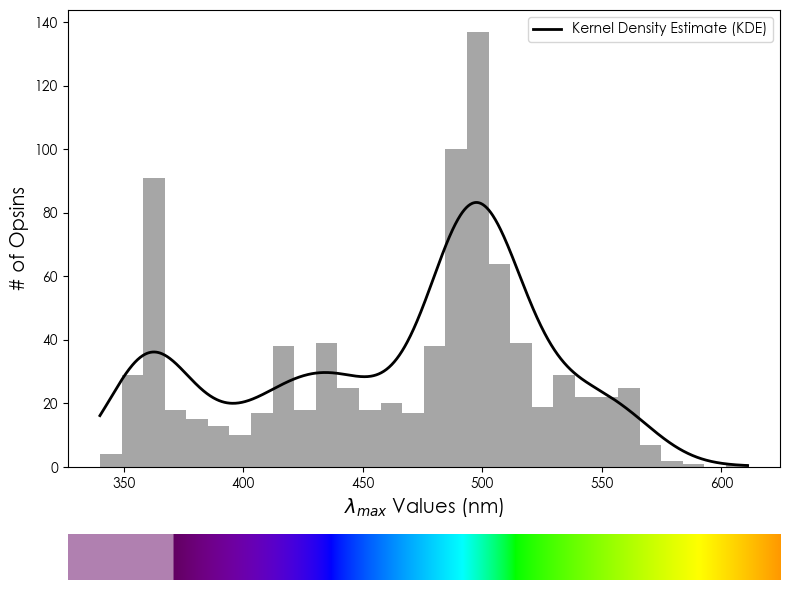

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib import font_manager as fm



#Adding in out desired font - feel free to change. :)
gothic_font = fm.FontProperties(fname='C:/Windows/Fonts/Gothic.ttf')
plt.rcParams['font.family'] = gothic_font.get_name()

# Sample lambda max values (replace with your actual data)
lambda_max_values = [497.9,503.8,498,499.4,500,501.5,491.5,494.5,483,498,499,497.5,501,495,495.5,498.5,493,499.5,498,489,502,491,498,479,488,486,482,482,497,526,501,507,484,504,490,489,478,511,503,488,491,492,490,501,504,495,488,501,488,499,498,494,501,490,502,494,486,488,485,496,483,526,489,492,507,486,491,479,504,501,501,501,501,482,502,501,502,496,485,486,500,500,493,500,498,495,499,492,501,488,487,498,502,500,497,488,501,504,496,500,498,505,500,490,498,502,484,488,501,488,491,503,498,500,491,500,503,502,494,500,491,497,494,493,492,489,507,508,491,504,486,504,487,511,525,483,500,489,495,524,552,489,501,485,489,492,501,499,494,491,501,482,494,488,488,482,482,490,467,496,496,492,496,0,488,481,495,512,511,467,480,452,459,469,496,491,482,492,494,493,492,471,489,467,467,488,505,464,464,463,465,467,465,468,466,470,471,472,501,536,554,562.8,544,463,458,452,465,453,499,500,497,499,508,500,497,501,502,500,501,500,502,502,501,498,499,500,359,355,423,356,358,360,393,359,415,365,414,359,358,420,419,420,489,488,484,501,498,502,465,453,452,458,571,540,538,542,547,561,565,569,542,558,560,561,566,556,550,543,545,543,550,547,548,546,550,543,552,554,551,551,549,463,482,485,452,466,502,510,514,520,512,514,500,492,505,502,502,500,506,502,502,503,511,506,495,467,503,505,508,359,415,443,437,448,441,455,559,561,558,560,571,530,560,553,509,508,509,524,553,545,531,516,532,482,481,359,359,397,397,382,363,405,369,371,389,358,359,435,500,569,352,578,450,440,528,530,516,527,526,528,475,508,535,520,526,533,528,571,562,516,519,516,476,438,408,353,503,358,439,497,492,420,363,388,357,366,380,419,372,419,360,420,361,360,508,505,502,498,414,424,417,434,383,491,492,491,502,489,461,484,377,480,485,486,486,484,481,450,437,446,425,420,430,561,500,499,404,450,486,479,539,502,525,521,509,510,521,513,515,513,496,508,505,498,505,500,494,505,420,360,360,435,431,430,429,430,431,435,439,431,452,516,492,448,516,494,447,517,486,469,516,491,460,519,491,462,517,493,493,516,508,0,512,508,508,510,508,508,516,515,514,516,515,516,516,514,0,513,514,515,469,454,463,462,485,416,452,466,438,408,439,405,448,397,416,443,416,418,416,417,416,417,418,417,417,417,416,419,443,443,442,440,437,441,444,443,442,442,487,484,477,498,453,467,476,488,505,528,519,484,423,368,511,505,502,502,481,494,494,491,486,490,490,499,493,508,508,508,508,509,503,488,491,491,489,505,488,489,474,524,488,499,497,478,495,493,511,491,484,499,361,360,359,360,360,393,359,360,361,362,361,361,361,392,392,398,392,359,377,357,383,357,369,374,374,374,374,375,375,360,393,393,366,360,398,360,360,359,383,410,389,417,421,422,360,361,404,404,408,404,418,355,380,408,385,411,421,422,361,359,394,360,355,359,361,370,359,361,357,360,391,391,360,359,363,361,358,363,363,383,385,423,365,360,360,396,414,414,381,363,405,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,381,363,403,395,412,411,352,369,352,369,498,367,412,416,359,360,411,360,552,558,363,511,431,356,357,442,584,509,572,507,352,359,358,507,511,519,563,563,561,558,558,536,561,564,532,553,532,533,532,554,553,532,534,533,532,501.7,499,359,376,358,358,424,430,354,367,361,431,403,363,403,365,363,539,611,542,557,577,532,532,537,518,500,499,482,482,482,431,443,433,363,370,365,430,353,353,0,415,352,365,371,0,429,425,485,482,494,490,551,539,532,532,533,533,545,545,546,546,558,559,556,559,555,536,550,543,527,533,545,536,525,522,516,534,512,532,439,439,438,438,438,439,438,439,442,438,439,444,448,444,449,448,450,453,430,500,340,430,485,347,486,344,436,434,435,377,434,436,437,434,435,437,420,421,488,345,375,439,353,487.3,380,350,450,513]
lambda_max_values_filtered = [value for value in lambda_max_values if value != 0]
lambda_max_values = lambda_max_values_filtered

# Create figure and axes for the histogram
fig, axs = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [10, 1]})
ax_hist = axs[0]

# Histogram subplot without density
n, bins, patches = ax_hist.hist(lambda_max_values, bins=30, color='gray', edgecolor='none', alpha=0.7)

# Overlay KDE curve scaled by the total number of items
kde = gaussian_kde(lambda_max_values)
x_vals = np.linspace(min(lambda_max_values), max(lambda_max_values), 1000)
y_vals = kde(x_vals) * len(10*lambda_max_values)  # Scale KDE by the total number of items
ax_hist.plot(x_vals, y_vals, color='black', linewidth=2, label='Kernel Density Estimate (KDE)')

# Customize histogram plot
ax_hist.set_xlabel('$\lambda_{max}$ Values (nm)', fontsize=14)
ax_hist.set_ylabel('# of Opsins', fontsize=14)
#ax_hist.set_title('Distribution of Opsin Light Sensitivity Data ($\lambda_{max}$) with KDE', fontsize=16)
ax_hist.legend()

# Color bar subplot
ax_colorbar = axs[1]

# Wavelength range for the visible spectrum in nanometers
#wavelengths_colorbar = np.linspace(300, 620, 1000)

# Wavelength range for the color background in nanometers
wavelengths_background = np.linspace(min(lambda_max_values), max(lambda_max_values), 1000)

background_colors = [wavelength_to_rgb(w) for w in wavelengths_background]

# Create a colormap representing the visible spectrum
spectrum_colormap = create_spectrum_colormap()

# Create an image with a single row and a smooth gradient colormap
image = ax_colorbar.imshow([background_colors], cmap=spectrum_colormap, aspect='auto', extent=[300, 620, 0, 1])

# Customize color bar plot
ax_colorbar.set_xlim(300, 620)
ax_colorbar.set_ylim(0, 1)
ax_colorbar.axis('off')

# Add color bar
#cbar = plt.colorbar(image, ax=ax_colorbar, orientation='horizontal', pad=0.04, aspect=50)
#cbar.set_label('Wavelength (nm)', fontsize=12)

# Adjust layout and save the plots
plt.tight_layout()
fileout = 'histogram_with_scaled_kde_and_colorbar.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight', dpi=300)
plt.show()

In [17]:
#for adding the opsin family meta-data to the opsin trees made for phylogenetic imputation...
import pandas as pd
def find_replace_and_save(file_path, search_list, replace_list, output_file_path):
    # Read the content of the file
    with open(file_path, 'r') as file:
        content = file.read()

    # Perform iterative find and replace
    for search_term, replace_term in zip(search_list, replace_list):
        search_term = search_term + ':'
        replace_term = search_term[:-1] + '_' + replace_term + ':'
        content = content.replace(search_term, replace_term)

    # Write the modified content to a new file
    with open(output_file_path, 'w') as output_file:
        output_file.write(content)

# Example usage:
input_file_path = 'nmoc_tree.tre'
output_file_path = 'nmoc_tree_ogf.tre'

# Define matches and replacements
wt_metadata = "nmoc_meta.tsv"
wt_meta = pd.read_csv(wt_metadata, sep="\t", index_col = 0)

search_list = list(wt_meta.index.values)
print(search_list)
replace_list = list(wt_meta['Opsin_Family'])
print(replace_list)

find_replace_and_save(input_file_path, search_list, replace_list, output_file_path)



['Bovine', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32', 'S33', 'S34', 'S35', 'S36', 'S37', 'S38', 'S39', 'S40', 'S41', 'S42', 'S43', 'S44', 'S45', 'S46', 'S47', 'S48', 'S49', 'S50', 'S51', 'S52', 'S53', 'S54', 'S55', 'S56', 'S57', 'S58', 'S59', 'S60', 'S61', 'S62', 'S63', 'S64', 'S65', 'S66', 'S67', 'S68', 'S69', 'S70', 'S71', 'S72', 'S73', 'S74', 'S75', 'S76', 'S77', 'S78', 'S79', 'S80', 'S81', 'S82', 'S83', 'S84', 'S85', 'S86', 'S87', 'S88', 'S89', 'S90', 'S91', 'S92', 'S93', 'S94', 'S95', 'S96', 'S97', 'S98', 'S99', 'S100', 'S101', 'S102', 'S103', 'S104', 'S105', 'S106', 'S107', 'S108', 'S109', 'S110', 'S111', 'S112', 'S113', 'S114', 'S115', 'S116', 'S117', 'S118', 'S119', 'S120', 'S121', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S131', 'S132', 'S133', 'S134', 'S135', 'S136', 'S137', '

: 

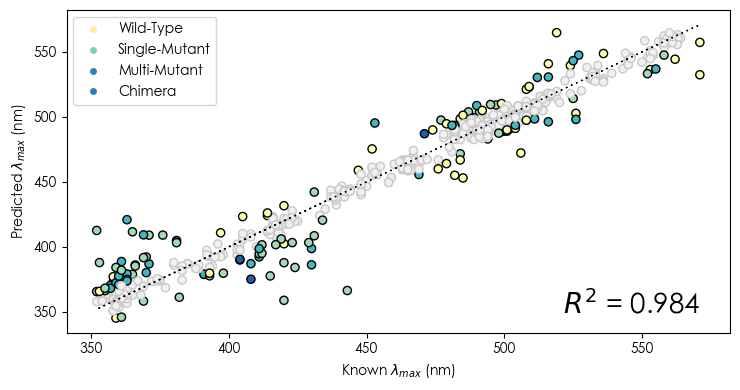

<Figure size 750x400 with 0 Axes>

In [30]:
from scipy import stats
import re
import joblib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from deepBreaks.preprocessing import read_data

directory = './results_4_paper/full_iter_sample_tests/'
metaDataFileName = "./vizphiz_data_splits_2023-10-16_12-13-11/wds_ni_meta.tsv"
testFileName = f"{directory}vert_test_results.csv"
phylum_list = []
data_set = 'vert2'

meta_data = read_data(metaDataFileName, seq_type = None, is_main=False)
base_test = read_data(testFileName, seq_type = None, is_main=False)

for phyla in base_test.index:
    #print(phyla)
    phylum_list.append(meta_data.Phylum[phyla])
#print(phylum_list)

#adding in the predicted lamda max into the test df
#adding the difference between predicted and known lambda max into df
base_test['Phylum'] = phylum_list
edgecolors = []
colors = []
for ind in base_test.index:
    if abs(base_test['Difference'][ind]) >= 10:
        edgecolors.append('k')
        if base_test['Phylum'][ind] == 'Chordata':
        #Vertebrate Opsins
            if '-' in base_test['Accession'][ind]:
                #dark blue - chimeras
                colors.append('#225ea8')
            elif base_test['Accession'][ind].count('_') > 1 or base_test['Accession'][ind].count(',') >= 1:
                p = re.compile('^.._')
                if p.match(base_test['Accession'][ind]) and base_test['Accession'][ind].count('_') == 2:
                    #green-blue - one mutation
                    colors.append('#a1dab4')
                    
                else:
                    #blue - multiple mutations
                    colors.append('#41b6c4')
            elif base_test['Accession'][ind].count('_') == 0 and base_test['Accession'][ind].count(',') == 0:
                #light-yellow - WT
                colors.append('#ffffb2')
            else:
                #green-blue - one mutation
                colors.append('#a1dab4')
                
        else:
            #Invertebrate opsins
            if '-' in base_test['Accession'][ind]:
                #purple - chimera
                colors.append('#7900A9')
                
            elif base_test['Accession'][ind].count('_') > 1 or base_test['Accession'][ind].count(',') > 1:
                p = re.compile('^.._')
                if p.match(base_test['Accession'][ind]) and base_test['Accession'][ind].count('_') == 2:
                    #orange - one mutation 
                    colors.append('#fc8d59')
                else:
                    #red - mutiple mutations
                    colors.append('#d73027')
            elif base_test['Accession'][ind].count('_') == 0 and base_test['Accession'][ind].count(',') == 0:
                #yellow - WT
                colors.append('#fee090')
            else:
                #orange - One mutation
                colors.append('#fc8d59')
    else:
        colors.append('#f0f0f0')
        edgecolors.append('#c9c9c9')

#plotting the predicted vs. known lambda max values...

#Adding in out desired font - feel free to change. :)
plt.rcParams['font.family'] = 'Century Gothic'

plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [7.50, 4.00]
#plt.title("$λ_{max}$ Predictions for Vertebrate Opsin Dataset")
plt.scatter(base_test['Lambda_Max'], base_test['Prediction'], c=colors, ec = edgecolors, edgecolors='k', s = 35)
plt.plot(base_test['Lambda_Max'], base_test['Lambda_Max'], c = 'k', linewidth = '1.0', ls = '--', dashes = (1,3))
plt.xlabel('Known $λ_{max}$ (nm)')
plt.ylabel('Predicted $λ_{max}$ (nm)')

legend_handles = [plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#ffeda0', markersize=12),
                  plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#7fcdbb', markersize=12),
                  plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#2c7fb8', markersize=12),
                  plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#2c7fb8', markersize=12)]
legend_labels = ['Wild-Type','Single-Mutant', 'Multi-Mutant', 'Chimera']

# Adjust bbox_to_anchor values to place the legend inside the graph
plt.legend(handles=legend_handles, labels=legend_labels, loc='upper left')

#plot and adjust position of the R^2 value
#plt.text(f"$R^2$ = {stats.linregress(base_test['Lambda_Max'],base_test['Prediction'])[2]:.3f}", ha='right', va='bottom', fontsize=20, c='k')
plt.annotate(f"$R^2$ = {stats.linregress(base_test['Lambda_Max'],base_test['Prediction'])[2]:.3f}", (max(base_test['Lambda_Max']), min(base_test['Prediction'])), ha='right', va='bottom', fontsize=20, c='k')

#plt.xticks(range(min(umd), max(umd)+1))
fileout = 'vert_iter_test.pdf'
plt.savefig(fileout)
fileout = 'vert_iter_test.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight')
plt.show()
plt.clf()
plt.show()

base_test['Colors'] = colors
base_test = base_test[['Species', 'Phylum', 'Opsin_Family', 'Accession','Lambda_Max','Prediction','Difference','Colors']]
#writing df to a csv file for secondary analysis in report directory
base_test.to_csv(path_or_buf= f'{directory}revised_basetest_results.csv',index = 'Feature',mode="w")

In [ ]:
report_dir = ""
inv = 'Chordata'
model_testing_report = f'{report_dir}/model_testing report.tsv'
predictions = model_testing_report
mut_metadata = path + "mut_meta.tsv"
mut_meta = pd.read_csv(mut_metadata, sep="\t", index_col = 0)
mut_meta = mut_meta.drop(mut_meta.index[0])
#mut_meta.head()
mut_meta['Prediction'] = predictions
mut_meta['Difference'] = mut_meta['Prediction'] - mut_meta['Lambda_Max']

mut_meta = mut_meta[['Species', 'Phylum','Opsin_Family', 'Accession','Lambda_Max','Prediction','Difference']]
mut_meta.to_csv(path_or_buf= f'{report_dir}/mut_results.csv',index = 'Feature',mode="w")
true_lmax = mut_meta['Lambda_Max']
mut_meta.head()

wt_metadata = path + "nmoc_meta.tsv"
wt_meta = pd.read_csv(wt_metadata, sep="\t", index_col = 0)

edgecolors = []
colors = []
wt_acc_list = []
wt_lmax = []
mut_diff = []
for ind in mut_meta.index:
    if abs(mut_meta['Difference'][ind]) >= 10:
        if inv != mut_meta['Phylum'][ind]:
            if '-' in mut_meta['Accession'][ind]:
                colors.append('#2c7fb8')
            elif mut_meta['Accession'][ind].count('_') > 1 or mut_meta['Accession'][ind].count(',') > 1:
                p = re.compile('^.._')
                if p.match(mut_meta['Accession'][ind]) and mut_meta['Accession'][ind].count('_') == 2:
                    colors.append('#ffeda0')
                else:
                    colors.append('#7fcdbb')
            else:
                colors.append('#ffeda0')
        else:
            if '-' in mut_meta['Accession'][ind]:
                colors.append('#2c7fb8')
            elif mut_meta['Accession'][ind].count('_') > 1 or mut_meta['Accession'][ind].count(',') >= 1:
                p = re.compile('^.._')
                if p.match(mut_meta['Accession'][ind]) and mut_meta['Accession'][ind].count('_') == 2:
                    colors.append('#ffeda0')
                else:
                    colors.append('#7fcdbb')
            else:
                colors.append('#ffeda0')
    else:
        colors.append('#f0f0f0')
    
    repeat_check = 0
    for wt in wt_meta.index:
        if repeat_check < 1:
            acc = wt_meta['Accession'][wt]
            acc = acc.split('.')[0]
            wt_acc = re.compile(f"^{acc}")

            if wt_acc.match(mut_meta['Accession'][ind]):
                if abs(wt_meta['Lambda_Max'][wt]-mut_meta['Lambda_Max'][ind]) >= 10:
                    edgecolors.append('#762a83')
                else:
                    edgecolors.append('#c9c9c9')
                diff = abs(wt_meta['Lambda_Max'][wt]-mut_meta['Lambda_Max'][ind])
                mut_diff.append(diff)
                wt_acc_list.append(wt_meta['Accession'][wt])
                wt_lmax.append(wt_meta['Lambda_Max'][wt])

                repeat_check += 1
            else:
                pass
        else:
            pass
    if repeat_check == 0:
        edgecolors.append('#c9c9c9')
        mut_diff.append('NA')
        wt_acc_list.append('No Match')
        wt_lmax.append('NA')
    else:
        pass

mut_wt_comp = pd.DataFrame()
mut_wt_comp["Mut_Acc"] = mut_meta["Accession"]
mut_wt_comp["WT_Acc"] = wt_acc_list
mut_wt_comp["Mut_Lmax"] = mut_meta["Lambda_Max"]
mut_wt_comp["WT_Lmax"] = wt_lmax
mut_wt_comp["Abs_Diff"] = mut_diff
mut_wt_comp["Edge_Colors"] = edgecolors
mut_wt_comp.to_csv(path_or_buf= f'{report_dir}/wt_mut_comp.csv',index_label=True,mode="w")

# Create a new column 'Marker' based on 'Phylum'
mut_meta['Marker'] = np.where(mut_meta['Phylum'] == inv, 'o', 's')

markers = mut_meta['Marker'].tolist()

#Adding in out desired font - feel free to change. :)
plt.rcParams['font.family'] = 'Century Gothic'
plt.rcParams["figure.figsize"] = [7.50, 4.00]
#plt.title("$λ_{max}$ Predictions for Unseen Mutant Data")

mask_o = np.array(markers) == 'o'
mask_s = np.array(markers) == 's'

# Create two separate scatter plots for invertebrates and vertebrates
scatter1 = plt.scatter(true_lmax[mask_o], predictions[mask_o], c=np.array(colors)[mask_o], ec=np.array(edgecolors)[mask_o], edgecolors='k', s=35, alpha=1.0, marker='o', label='Invertebrates')
scatter2 = plt.scatter(true_lmax[mask_s], predictions[mask_s], c=np.array(colors)[mask_s], ec=np.array(edgecolors)[mask_s], edgecolors='k', s=35, alpha=1.0, marker='s', label='Vertebrates')


plt.plot(true_lmax, true_lmax, c='k', linewidth='1.0', ls='--', dashes=(1, 3))
plt.xlabel('Known $λ_{max}$ (nm)')
plt.ylabel('Predicted $λ_{max}$ (nm)')
plt.annotate(f"$R^2$ = {load_top_mod.score(mut, true_lmax):.3f}", (max(true_lmax), min(predictions)), ha='right', va='bottom', fontsize=18, c='k')
# Custom legend handles and labels
legend_handles = [scatter1, scatter2, plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#ffeda0', markersize=12), plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#7fcdbb', markersize=12), plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#2c7fb8', markersize=12)]
legend_labels = ['Invertebrates', 'Vertebrates', 'Single-Mutant', 'Multi-Mutant', 'Chimera']

# Add legend on the top left corner
plt.legend(handles=legend_handles, labels=legend_labels, loc='upper left')

fileout = f'{report_dir}/final_wt_mut_test.pdf'
plt.savefig(fileout)
fileout = 'final_wt_mut_test.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight')
plt.show()
plt.clf()
plt.show()

model_testing_report = f'{report_dir}/model_testing report.tsv'

base_rsq = load_top_mod.score(mut, true_lmax)
print(base_rsq)

base_mae = mean_absolute_error(predictions, true_lmax)
print(base_mae)

base_mape = mean_absolute_percentage_error(predictions, true_lmax)
print(base_mape)

base_sqe = mean_squared_error(predictions, true_lmax)
print(base_sqe)

base_rsqe = mean_squared_error(predictions, true_lmax, squared=False)
print(base_rsqe)

with open(model_testing_report, 'w') as f:
    f.write(f'Base Model R^2\tBase Model MAE\tBase Model MAPE\tBase Model SQE\tBase Model RSQE\n')
    f.write(f'{str(base_rsq)}\t{str(base_mae)}\t{str(base_mape)}\t{str(base_sqe)}\t{str(base_rsqe)}')

c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


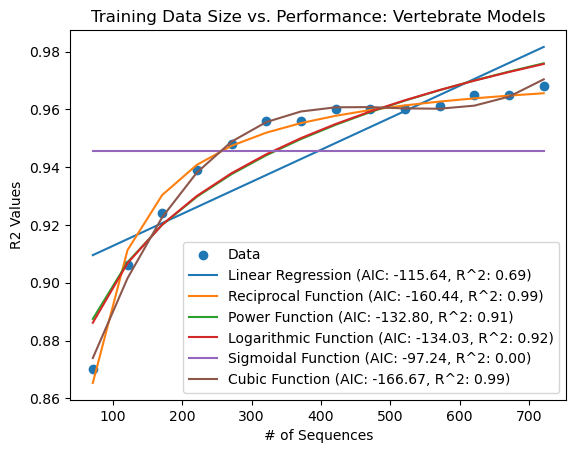

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Given data
# Data from Rivers and Morin, in units of mm
x = np.array([721, 671, 621, 571, 521, 471, 421, 371, 321, 271, 221, 171, 121, 71])  # Number of data points
y = np.array([0.968, 0.965, 0.965, 0.961, 0.960, 0.960, 0.960, 0.956, 0.956, 0.948, 0.939, 0.924, 0.906, 0.870])  # R^2 values

# Fit linear regression model
reg_linear = LinearRegression().fit(x.reshape(-1, 1), y)
a_linear = reg_linear.intercept_
b_linear = reg_linear.coef_[0]
y_predicted_linear = a_linear + b_linear * x
r2_linear = r2_score(y, y_predicted_linear)

# Reciprocal function
def reciprocal(x, a, b):
    return a / x + b

# Fit reciprocal model
reciprocal_params, _ = curve_fit(reciprocal, x, y)
a_reciprocal, b_reciprocal = reciprocal_params
y_predicted_reciprocal = reciprocal(x, a_reciprocal, b_reciprocal)
r2_reciprocal = r2_score(y, y_predicted_reciprocal)

# Power function model
def power_function(x, a, b):
    return a * np.power(x, b)

# Fit power function model
power_params, _ = curve_fit(power_function, x, y)
a_power, b_power = power_params
y_predicted_power = power_function(x, a_power, b_power)
r2_power = r2_score(y, y_predicted_power)

# Logarithmic function model
def logarithmic_function(x, a, b):
    return a * np.log(x) + b

# Fit logarithmic function model
logarithmic_params, _ = curve_fit(logarithmic_function, x, y)
a_logarithmic, b_logarithmic = logarithmic_params
y_predicted_logarithmic = logarithmic_function(x, a_logarithmic, b_logarithmic)
r2_logarithmic = r2_score(y, y_predicted_logarithmic)

# Sigmoidal function model
def sigmoidal_function(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

# Fit sigmoidal function model
sigmoidal_params, _ = curve_fit(sigmoidal_function, x, y)
a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal = sigmoidal_params
y_predicted_sigmoidal = sigmoidal_function(x, a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal)
r2_sigmoidal = r2_score(y, y_predicted_sigmoidal)

# Cubic function model
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# Fit cubic function model
cubic_params, _ = curve_fit(cubic_function, x, y)
a_cubic, b_cubic, c_cubic, d_cubic = cubic_params
y_predicted_cubic = cubic_function(x, a_cubic, b_cubic, c_cubic, d_cubic)
r2_cubic = r2_score(y, y_predicted_cubic)

# Calculate AIC values
aic_linear = 2 + len(x) * np.log(np.sum((y - y_predicted_linear)**2) / len(x))
aic_reciprocal = 2 + len(x) * np.log(np.sum((y - y_predicted_reciprocal)**2) / len(x))
aic_power = 2 + len(x) * np.log(np.sum((y - y_predicted_power)**2) / len(x))
aic_logarithmic = 2 + len(x) * np.log(np.sum((y - y_predicted_logarithmic)**2) / len(x))
aic_sigmoidal = 4 + len(x) * np.log(np.sum((y - y_predicted_sigmoidal)**2) / len(x))
aic_cubic = 4 + len(x) * np.log(np.sum((y - y_predicted_cubic)**2) / len(x))

# Plot data and fitted models
plt.scatter(x, y, label='Data')
plt.plot(x, y_predicted_linear, label=f'Linear Regression (AIC: {aic_linear:.2f}, R^2: {r2_linear:.2f})')
plt.plot(x, y_predicted_reciprocal, label=f'Reciprocal Function (AIC: {aic_reciprocal:.2f}, R^2: {r2_reciprocal:.2f})')
plt.plot(x, y_predicted_power, label=f'Power Function (AIC: {aic_power:.2f}, R^2: {r2_power:.2f})')
plt.plot(x, y_predicted_logarithmic, label=f'Logarithmic Function (AIC: {aic_logarithmic:.2f}, R^2: {r2_logarithmic:.2f})')
plt.plot(x, y_predicted_sigmoidal, label=f'Sigmoidal Function (AIC: {aic_sigmoidal:.2f}, R^2: {r2_sigmoidal:.2f})')
plt.plot(x, y_predicted_cubic, label=f'Cubic Function (AIC: {aic_cubic:.2f}, R^2: {r2_cubic:.2f})')
plt.xlabel('# of Sequences')
plt.ylabel('R2 Values')
plt.legend()
plt.title('Training Data Size vs. Performance: Vertebrate Models')
plt.show()


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Given data
# Data from Rivers and Morin, in units of mm
x = np.array([721, 671, 621, 571, 521, 471, 421, 371, 321, 271, 221, 171, 121, 71])  # Number of data points
y = np.array([0.968, 0.965, 0.965, 0.961, 0.960, 0.960, 0.960, 0.956, 0.956, 0.948, 0.939, 0.924, 0.906, 0.870])  # R^2 values

# Fit linear regression model
reg_linear = LinearRegression().fit(x.reshape(-1, 1), y)
a_linear = reg_linear.intercept_
b_linear = reg_linear.coef_[0]
y_predicted_linear = a_linear + b_linear * x
r2_linear = r2_score(y, y_predicted_linear)
equation_linear = f'Linear: y = {a_linear:.4f} + {b_linear:.4f} * x'

# Reciprocal function
def reciprocal(x, a, b):
    return a / x + b

# Fit reciprocal model
reciprocal_params, _ = curve_fit(reciprocal, x, y)
a_reciprocal, b_reciprocal = reciprocal_params
y_predicted_reciprocal = reciprocal(x, a_reciprocal, b_reciprocal)
r2_reciprocal = r2_score(y, y_predicted_reciprocal)
equation_reciprocal = f'Reciprocal: y = {a_reciprocal:.4f} / x + {b_reciprocal:.4f}'

# Power function model
def power_function(x, a, b):
    return a * np.power(x, b)

# Fit power function model
power_params, _ = curve_fit(power_function, x, y)
a_power, b_power = power_params
y_predicted_power = power_function(x, a_power, b_power)
r2_power = r2_score(y, y_predicted_power)
equation_power = f'Power: y = {a_power:.4f} * x^{b_power:.4f}'

# Logarithmic function model
def logarithmic_function(x, a, b):
    return a * np.log(x) + b

# Fit logarithmic function model
logarithmic_params, _ = curve_fit(logarithmic_function, x, y)
a_logarithmic, b_logarithmic = logarithmic_params
y_predicted_logarithmic = logarithmic_function(x, a_logarithmic, b_logarithmic)
r2_logarithmic = r2_score(y, y_predicted_logarithmic)
equation_logarithmic = f'Logarithmic: y = {a_logarithmic:.4f} * log(x) + {b_logarithmic:.4f}'

# Sigmoidal function model
def sigmoidal_function(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

# Fit sigmoidal function model
sigmoidal_params, _ = curve_fit(sigmoidal_function, x, y)
a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal = sigmoidal_params
y_predicted_sigmoidal = sigmoidal_function(x, a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal)
r2_sigmoidal = r2_score(y, y_predicted_sigmoidal)
equation_sigmoidal = f'Sigmoidal: y = {a_sigmoidal:.4f} / (1 + e^(-{c_sigmoidal:.4f} * (x - {d_sigmoidal:.4f}))) + {b_sigmoidal:.4f}'

# Cubic function model
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# Fit cubic function model
cubic_params, _ = curve_fit(cubic_function, x, y)
a_cubic, b_cubic, c_cubic, d_cubic = cubic_params
y_predicted_cubic = cubic_function(x, a_cubic, b_cubic, c_cubic, d_cubic)
r2_cubic = r2_score(y, y_predicted_cubic)
equation_cubic = f'Cubic: y = {a_cubic:.4f} * x^3 + {b_cubic:.4f} * x^2 + {c_cubic:.4f} * x + {d_cubic:.4f}'

# Exponential decay function model with y-offset
def exponential_decay_with_offset(x, a, b, c):
    return a * np.exp(-b * x) + c

# Fit exponential decay function model with y-offset
exp_decay_params, _ = curve_fit(exponential_decay_with_offset, x, y)
a_exp_decay_with_offset, b_exp_decay_with_offset, c_exp_decay_with_offset = exp_decay_params
y_predicted_exp_decay_with_offset = exponential_decay_with_offset(x, a_exp_decay_with_offset, b_exp_decay_with_offset, c_exp_decay_with_offset)
r2_exp_decay_with_offset = r2_score(y, y_predicted_exp_decay_with_offset)

# Display equations
print("Equations for Best-Fit Lines:")
print(equation_linear)
print(equation_reciprocal)
print(equation_power)
print(equation_logarithmic)
print(equation_sigmoidal)
print(equation_cubic)


Equations for Best-Fit Lines:
Linear: y = 0.9017 + 0.0001 * x
Reciprocal: y = -7.8952 / x + 0.9765
Power: y = 0.7452 * x^0.0410
Logarithmic: y = 0.0386 * log(x) + 0.7215
Sigmoidal: y = -103.3921 / (1 + e^(-1.0000 * (x - 1.0000))) + 104.3377
Cubic: y = 0.0000 * x^3 + -0.0000 * x^2 + 0.0008 * x + 0.8219
Exponential Decay with Offset: y = 1.0000 * e^(-1.0000 * x) + 0.9456


c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


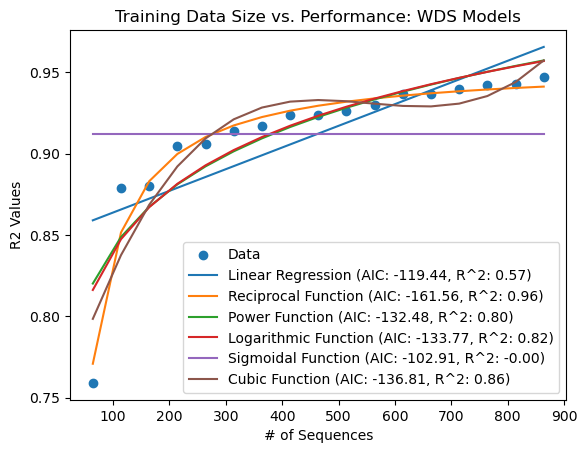

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Given data
x = np.array([864,814,764,714,664,614,564,514,464,414,364,314,264,214,164,114,64])  # Number of data points
y = np.array([0.947,0.943,0.942,0.940,0.937,0.937,0.930,0.926,0.924,0.924,0.917,0.914,0.906,0.905,0.880,0.879,0.759])  # R^2 values

# Fit linear regression model
reg_linear = LinearRegression().fit(x.reshape(-1, 1), y)
a_linear = reg_linear.intercept_
b_linear = reg_linear.coef_[0]
y_predicted_linear = a_linear + b_linear * x
r2_linear = r2_score(y, y_predicted_linear)

# Reciprocal function
def reciprocal(x, a, b):
    return a / x + b

# Fit reciprocal model
reciprocal_params, _ = curve_fit(reciprocal, x, y)
a_reciprocal, b_reciprocal = reciprocal_params
y_predicted_reciprocal = reciprocal(x, a_reciprocal, b_reciprocal)
r2_reciprocal = r2_score(y, y_predicted_reciprocal)

# Power function model
def power_function(x, a, b):
    return a * np.power(x, b)

# Fit power function model
power_params, _ = curve_fit(power_function, x, y)
a_power, b_power = power_params
y_predicted_power = power_function(x, a_power, b_power)
r2_power = r2_score(y, y_predicted_power)

# Logarithmic function model
def logarithmic_function(x, a, b):
    return a * np.log(x) + b

# Fit logarithmic function model
logarithmic_params, _ = curve_fit(logarithmic_function, x, y)
a_logarithmic, b_logarithmic = logarithmic_params
y_predicted_logarithmic = logarithmic_function(x, a_logarithmic, b_logarithmic)
r2_logarithmic = r2_score(y, y_predicted_logarithmic)

# Sigmoidal function model
def sigmoidal_function(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

# Fit sigmoidal function model
sigmoidal_params, _ = curve_fit(sigmoidal_function, x, y)
a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal = sigmoidal_params
y_predicted_sigmoidal = sigmoidal_function(x, a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal)
r2_sigmoidal = r2_score(y, y_predicted_sigmoidal)

# Cubic function model
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# Fit cubic function model
cubic_params, _ = curve_fit(cubic_function, x, y)
a_cubic, b_cubic, c_cubic, d_cubic = cubic_params
y_predicted_cubic = cubic_function(x, a_cubic, b_cubic, c_cubic, d_cubic)
r2_cubic = r2_score(y, y_predicted_cubic)

# Calculate AIC values
aic_linear = 2 + len(x) * np.log(np.sum((y - y_predicted_linear)**2) / len(x))
aic_reciprocal = 2 + len(x) * np.log(np.sum((y - y_predicted_reciprocal)**2) / len(x))
aic_power = 2 + len(x) * np.log(np.sum((y - y_predicted_power)**2) / len(x))
aic_logarithmic = 2 + len(x) * np.log(np.sum((y - y_predicted_logarithmic)**2) / len(x))
aic_sigmoidal = 4 + len(x) * np.log(np.sum((y - y_predicted_sigmoidal)**2) / len(x))
aic_cubic = 4 + len(x) * np.log(np.sum((y - y_predicted_cubic)**2) / len(x))

# Plot data and fitted models
plt.scatter(x, y, label='Data')
plt.plot(x, y_predicted_linear, label=f'Linear Regression (AIC: {aic_linear:.2f}, R^2: {r2_linear:.2f})')
plt.plot(x, y_predicted_reciprocal, label=f'Reciprocal Function (AIC: {aic_reciprocal:.2f}, R^2: {r2_reciprocal:.2f})')
plt.plot(x, y_predicted_power, label=f'Power Function (AIC: {aic_power:.2f}, R^2: {r2_power:.2f})')
plt.plot(x, y_predicted_logarithmic, label=f'Logarithmic Function (AIC: {aic_logarithmic:.2f}, R^2: {r2_logarithmic:.2f})')
plt.plot(x, y_predicted_sigmoidal, label=f'Sigmoidal Function (AIC: {aic_sigmoidal:.2f}, R^2: {r2_sigmoidal:.2f})')
plt.plot(x, y_predicted_cubic, label=f'Cubic Function (AIC: {aic_cubic:.2f}, R^2: {r2_cubic:.2f})')
plt.xlabel('# of Sequences')
plt.ylabel('R2 Values')
plt.legend()
plt.title('Training Data Size vs. Performance: WDS Models')
plt.show()

In [56]:
# Fit linear regression model
reg_linear = LinearRegression().fit(x.reshape(-1, 1), y)
a_linear = reg_linear.intercept_
b_linear = reg_linear.coef_[0]
y_predicted_linear = a_linear + b_linear * x
r2_linear = r2_score(y, y_predicted_linear)
equation_linear = f'Linear: y = {a_linear:.4f} + {b_linear:.4f} * x'

# Reciprocal function
def reciprocal(x, a, b):
    return a / x + b

# Fit reciprocal model
reciprocal_params, _ = curve_fit(reciprocal, x, y)
a_reciprocal, b_reciprocal = reciprocal_params
y_predicted_reciprocal = reciprocal(x, a_reciprocal, b_reciprocal)
r2_reciprocal = r2_score(y, y_predicted_reciprocal)
equation_reciprocal = f'Reciprocal: y = {a_reciprocal:.4f} / x + {b_reciprocal:.4f}'

# Power function model
def power_function(x, a, b):
    return a * np.power(x, b)

# Fit power function model
power_params, _ = curve_fit(power_function, x, y)
a_power, b_power = power_params
y_predicted_power = power_function(x, a_power, b_power)
r2_power = r2_score(y, y_predicted_power)
equation_power = f'Power: y = {a_power:.4f} * x^{b_power:.4f}'

# Logarithmic function model
def logarithmic_function(x, a, b):
    return a * np.log(x) + b

# Fit logarithmic function model
logarithmic_params, _ = curve_fit(logarithmic_function, x, y)
a_logarithmic, b_logarithmic = logarithmic_params
y_predicted_logarithmic = logarithmic_function(x, a_logarithmic, b_logarithmic)
r2_logarithmic = r2_score(y, y_predicted_logarithmic)
equation_logarithmic = f'Logarithmic: y = {a_logarithmic:.4f} * log(x) + {b_logarithmic:.4f}'

# Sigmoidal function model
def sigmoidal_function(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

# Fit sigmoidal function model
sigmoidal_params, _ = curve_fit(sigmoidal_function, x, y)
a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal = sigmoidal_params
y_predicted_sigmoidal = sigmoidal_function(x, a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal)
r2_sigmoidal = r2_score(y, y_predicted_sigmoidal)
equation_sigmoidal = f'Sigmoidal: y = {a_sigmoidal:.4f} / (1 + e^(-{c_sigmoidal:.4f} * (x - {d_sigmoidal:.4f}))) + {b_sigmoidal:.4f}'

# Cubic function model
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# Fit cubic function model
cubic_params, _ = curve_fit(cubic_function, x, y)
a_cubic, b_cubic, c_cubic, d_cubic = cubic_params
y_predicted_cubic = cubic_function(x, a_cubic, b_cubic, c_cubic, d_cubic)
r2_cubic = r2_score(y, y_predicted_cubic)
equation_cubic = f'Cubic: y = {a_cubic:.4f} * x^3 + {b_cubic:.4f} * x^2 + {c_cubic:.4f} * x + {d_cubic:.4f}'

# Exponential decay function model with y-offset
def exponential_decay_with_offset(x, a, b, c):
    return a * np.exp(-b * x) + c

# Fit exponential decay function model with y-offset
exp_decay_params, _ = curve_fit(exponential_decay_with_offset, x, y)
a_exp_decay_with_offset, b_exp_decay_with_offset, c_exp_decay_with_offset = exp_decay_params
y_predicted_exp_decay_with_offset = exponential_decay_with_offset(x, a_exp_decay_with_offset, b_exp_decay_with_offset, c_exp_decay_with_offset)
r2_exp_decay_with_offset = r2_score(y, y_predicted_exp_decay_with_offset)

# Display equations
print("Equations for Best-Fit Lines:")
print(equation_linear)
print(equation_reciprocal)
print(equation_power)
print(equation_logarithmic)
print(equation_sigmoidal)
print(equation_cubic)


Equations for Best-Fit Lines:
Linear: y = 0.8505 + 0.0001 * x
Reciprocal: y = -11.7836 / x + 0.9549
Power: y = 0.6404 * x^0.0595
Logarithmic: y = 0.0541 * log(x) + 0.5911
Sigmoidal: y = -102.4809 / (1 + e^(-1.0000 * (x - 1.0000))) + 103.3933
Cubic: y = 0.0000 * x^3 + -0.0000 * x^2 + 0.0011 * x + 0.7347
Exponential Decay with Offset: y = 1.0000 * e^(-1.0000 * x) + 0.9124


c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


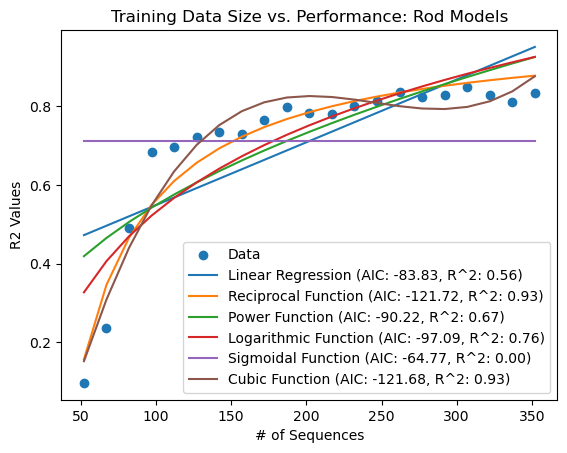

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Given data
x = np.array([352,337,322,307,292,277,262,247,232,217,202,187,172,157,142,127,112,97,82,67,52])  # Number of data points
y = np.array([0.834,0.812223,0.82989,0.848674,0.829916,0.823913,0.837994,0.813817,0.800248,0.780648,0.783326,0.798657,0.765678,0.730895,0.734695,0.721046,0.696243,0.685208,0.490642,0.236599,0.096072])  # R^2 values

# Fit linear regression model
reg_linear = LinearRegression().fit(x.reshape(-1, 1), y)
a_linear = reg_linear.intercept_
b_linear = reg_linear.coef_[0]
y_predicted_linear = a_linear + b_linear * x
r2_linear = r2_score(y, y_predicted_linear)

# Reciprocal function
def reciprocal(x, a, b):
    return a / x + b

# Fit reciprocal model
reciprocal_params, _ = curve_fit(reciprocal, x, y)
a_reciprocal, b_reciprocal = reciprocal_params
y_predicted_reciprocal = reciprocal(x, a_reciprocal, b_reciprocal)
r2_reciprocal = r2_score(y, y_predicted_reciprocal)

# Power function model
def power_function(x, a, b):
    return a * np.power(x, b)

# Fit power function model
power_params, _ = curve_fit(power_function, x, y)
a_power, b_power = power_params
y_predicted_power = power_function(x, a_power, b_power)
r2_power = r2_score(y, y_predicted_power)

# Logarithmic function model
def logarithmic_function(x, a, b):
    return a * np.log(x) + b

# Fit logarithmic function model
logarithmic_params, _ = curve_fit(logarithmic_function, x, y)
a_logarithmic, b_logarithmic = logarithmic_params
y_predicted_logarithmic = logarithmic_function(x, a_logarithmic, b_logarithmic)
r2_logarithmic = r2_score(y, y_predicted_logarithmic)

# Sigmoidal function model
def sigmoidal_function(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

# Fit sigmoidal function model
sigmoidal_params, _ = curve_fit(sigmoidal_function, x, y)
a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal = sigmoidal_params
y_predicted_sigmoidal = sigmoidal_function(x, a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal)
r2_sigmoidal = r2_score(y, y_predicted_sigmoidal)

# Cubic function model
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# Fit cubic function model
cubic_params, _ = curve_fit(cubic_function, x, y)
a_cubic, b_cubic, c_cubic, d_cubic = cubic_params
y_predicted_cubic = cubic_function(x, a_cubic, b_cubic, c_cubic, d_cubic)
r2_cubic = r2_score(y, y_predicted_cubic)

# Calculate AIC values
aic_linear = 2 + len(x) * np.log(np.sum((y - y_predicted_linear)**2) / len(x))
aic_reciprocal = 2 + len(x) * np.log(np.sum((y - y_predicted_reciprocal)**2) / len(x))
aic_power = 2 + len(x) * np.log(np.sum((y - y_predicted_power)**2) / len(x))
aic_logarithmic = 2 + len(x) * np.log(np.sum((y - y_predicted_logarithmic)**2) / len(x))
aic_sigmoidal = 4 + len(x) * np.log(np.sum((y - y_predicted_sigmoidal)**2) / len(x))
aic_cubic = 4 + len(x) * np.log(np.sum((y - y_predicted_cubic)**2) / len(x))

# Plot data and fitted models
plt.scatter(x, y, label='Data')
plt.plot(x, y_predicted_linear, label=f'Linear Regression (AIC: {aic_linear:.2f}, R^2: {r2_linear:.2f})')
plt.plot(x, y_predicted_reciprocal, label=f'Reciprocal Function (AIC: {aic_reciprocal:.2f}, R^2: {r2_reciprocal:.2f})')
plt.plot(x, y_predicted_power, label=f'Power Function (AIC: {aic_power:.2f}, R^2: {r2_power:.2f})')
plt.plot(x, y_predicted_logarithmic, label=f'Logarithmic Function (AIC: {aic_logarithmic:.2f}, R^2: {r2_logarithmic:.2f})')
plt.plot(x, y_predicted_sigmoidal, label=f'Sigmoidal Function (AIC: {aic_sigmoidal:.2f}, R^2: {r2_sigmoidal:.2f})')
plt.plot(x, y_predicted_cubic, label=f'Cubic Function (AIC: {aic_cubic:.2f}, R^2: {r2_cubic:.2f})')
plt.xlabel('# of Sequences')
plt.ylabel('R2 Values')
plt.legend()
plt.title('Training Data Size vs. Performance: Rod Models')
plt.show()

In [62]:
# Fit linear regression model
reg_linear = LinearRegression().fit(x.reshape(-1, 1), y)
a_linear = reg_linear.intercept_
b_linear = reg_linear.coef_[0]
y_predicted_linear = a_linear + b_linear * x
r2_linear = r2_score(y, y_predicted_linear)
equation_linear = f'Linear: y = {a_linear:.4f} + {b_linear:.4f} * x'

# Reciprocal function
def reciprocal(x, a, b):
    return a / x + b

# Fit reciprocal model
reciprocal_params, _ = curve_fit(reciprocal, x, y)
a_reciprocal, b_reciprocal = reciprocal_params
y_predicted_reciprocal = reciprocal(x, a_reciprocal, b_reciprocal)
r2_reciprocal = r2_score(y, y_predicted_reciprocal)
equation_reciprocal = f'Reciprocal: y = {a_reciprocal:.4f} / x + {b_reciprocal:.4f}'

# Power function model
def power_function(x, a, b):
    return a * np.power(x, b)

# Fit power function model
power_params, _ = curve_fit(power_function, x, y)
a_power, b_power = power_params
y_predicted_power = power_function(x, a_power, b_power)
r2_power = r2_score(y, y_predicted_power)
equation_power = f'Power: y = {a_power:.4f} * x^{b_power:.4f}'

# Logarithmic function model
def logarithmic_function(x, a, b):
    return a * np.log(x) + b

# Fit logarithmic function model
logarithmic_params, _ = curve_fit(logarithmic_function, x, y)
a_logarithmic, b_logarithmic = logarithmic_params
y_predicted_logarithmic = logarithmic_function(x, a_logarithmic, b_logarithmic)
r2_logarithmic = r2_score(y, y_predicted_logarithmic)
equation_logarithmic = f'Logarithmic: y = {a_logarithmic:.4f} * log(x) + {b_logarithmic:.4f}'

# Sigmoidal function model
def sigmoidal_function(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

# Fit sigmoidal function model
sigmoidal_params, _ = curve_fit(sigmoidal_function, x, y)
a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal = sigmoidal_params
y_predicted_sigmoidal = sigmoidal_function(x, a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal)
r2_sigmoidal = r2_score(y, y_predicted_sigmoidal)
equation_sigmoidal = f'Sigmoidal: y = {a_sigmoidal:.4f} / (1 + e^(-{c_sigmoidal:.4f} * (x - {d_sigmoidal:.4f}))) + {b_sigmoidal:.4f}'

# Cubic function model
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# Fit cubic function model
cubic_params, _ = curve_fit(cubic_function, x, y)
a_cubic, b_cubic, c_cubic, d_cubic = cubic_params
y_predicted_cubic = cubic_function(x, a_cubic, b_cubic, c_cubic, d_cubic)
r2_cubic = r2_score(y, y_predicted_cubic)
equation_cubic = f'Cubic: y = {a_cubic:.4f} * x^3 + {b_cubic:.4f} * x^2 + {c_cubic:.4f} * x + {d_cubic:.4f}'

# Exponential decay function model with y-offset
def exponential_decay_with_offset(x, a, b, c):
    return a * np.exp(-b * x) + c

# Fit exponential decay function model with y-offset
exp_decay_params, _ = curve_fit(exponential_decay_with_offset, x, y)
a_exp_decay_with_offset, b_exp_decay_with_offset, c_exp_decay_with_offset = exp_decay_params
y_predicted_exp_decay_with_offset = exponential_decay_with_offset(x, a_exp_decay_with_offset, b_exp_decay_with_offset, c_exp_decay_with_offset)
r2_exp_decay_with_offset = r2_score(y, y_predicted_exp_decay_with_offset)

# Display equations
print("Equations for Best-Fit Lines:")
print(equation_linear)
print(equation_reciprocal)
print(equation_power)
print(equation_logarithmic)
print(equation_sigmoidal)
print(equation_cubic)


Equations for Best-Fit Lines:
Linear: y = 0.3893 + 0.0016 * x
Reciprocal: y = -44.0622 / x + 1.0035
Power: y = 0.0812 * x^0.4150
Logarithmic: y = 0.3134 * log(x) + -0.9115
Sigmoidal: y = -101.9967 / (1 + e^(-1.0000 * (x - 1.0000))) + 102.7086
Cubic: y = 0.0000 * x^3 + -0.0001 * x^2 + 0.0187 * x + -0.6229
Exponential Decay with Offset: y = 1.0000 * e^(-1.0000 * x) + 0.7119


c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


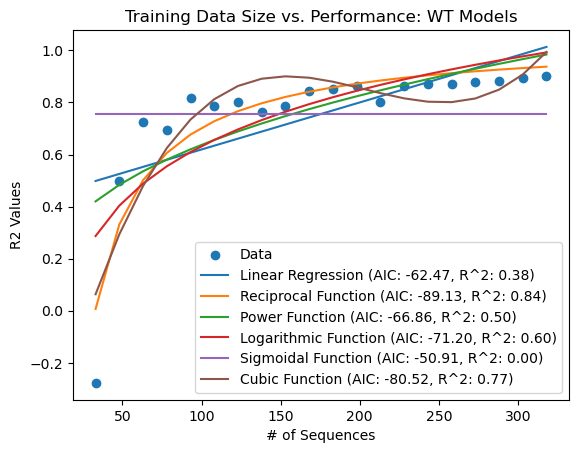

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Given data
# Data from Rivers and Morin, in units of mm
x = np.array([318,303,288,273,258,243,228,213,198,183,168,153,138,123,108,93,78,63,48,33])  # Number of data points
y = np.array([0.902,0.892,0.884,0.878,0.870,0.869,0.863,0.800,0.863,0.853,0.843,0.788,0.765,0.801,0.788,0.817,0.695,0.723,0.499,-0.277])  # R^2 values

# Fit linear regression model
reg_linear = LinearRegression().fit(x.reshape(-1, 1), y)
a_linear = reg_linear.intercept_
b_linear = reg_linear.coef_[0]
y_predicted_linear = a_linear + b_linear * x
r2_linear = r2_score(y, y_predicted_linear)

# Reciprocal function
def reciprocal(x, a, b):
    return a / x + b

# Fit reciprocal model
reciprocal_params, _ = curve_fit(reciprocal, x, y)
a_reciprocal, b_reciprocal = reciprocal_params
y_predicted_reciprocal = reciprocal(x, a_reciprocal, b_reciprocal)
r2_reciprocal = r2_score(y, y_predicted_reciprocal)

# Power function model
def power_function(x, a, b):
    return a * np.power(x, b)

# Fit power function model
power_params, _ = curve_fit(power_function, x, y)
a_power, b_power = power_params
y_predicted_power = power_function(x, a_power, b_power)
r2_power = r2_score(y, y_predicted_power)

# Logarithmic function model
def logarithmic_function(x, a, b):
    return a * np.log(x) + b

# Fit logarithmic function model
logarithmic_params, _ = curve_fit(logarithmic_function, x, y)
a_logarithmic, b_logarithmic = logarithmic_params
y_predicted_logarithmic = logarithmic_function(x, a_logarithmic, b_logarithmic)
r2_logarithmic = r2_score(y, y_predicted_logarithmic)

# Sigmoidal function model
def sigmoidal_function(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

# Fit sigmoidal function model
sigmoidal_params, _ = curve_fit(sigmoidal_function, x, y)
a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal = sigmoidal_params
y_predicted_sigmoidal = sigmoidal_function(x, a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal)
r2_sigmoidal = r2_score(y, y_predicted_sigmoidal)

# Cubic function model
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# Fit cubic function model
cubic_params, _ = curve_fit(cubic_function, x, y)
a_cubic, b_cubic, c_cubic, d_cubic = cubic_params
y_predicted_cubic = cubic_function(x, a_cubic, b_cubic, c_cubic, d_cubic)
r2_cubic = r2_score(y, y_predicted_cubic)

# Calculate AIC values
aic_linear = 2 + len(x) * np.log(np.sum((y - y_predicted_linear)**2) / len(x))
aic_reciprocal = 2 + len(x) * np.log(np.sum((y - y_predicted_reciprocal)**2) / len(x))
aic_power = 2 + len(x) * np.log(np.sum((y - y_predicted_power)**2) / len(x))
aic_logarithmic = 2 + len(x) * np.log(np.sum((y - y_predicted_logarithmic)**2) / len(x))
aic_sigmoidal = 4 + len(x) * np.log(np.sum((y - y_predicted_sigmoidal)**2) / len(x))
aic_cubic = 4 + len(x) * np.log(np.sum((y - y_predicted_cubic)**2) / len(x))

# Plot data and fitted models
plt.scatter(x, y, label='Data')
plt.plot(x, y_predicted_linear, label=f'Linear Regression (AIC: {aic_linear:.2f}, R^2: {r2_linear:.2f})')
plt.plot(x, y_predicted_reciprocal, label=f'Reciprocal Function (AIC: {aic_reciprocal:.2f}, R^2: {r2_reciprocal:.2f})')
plt.plot(x, y_predicted_power, label=f'Power Function (AIC: {aic_power:.2f}, R^2: {r2_power:.2f})')
plt.plot(x, y_predicted_logarithmic, label=f'Logarithmic Function (AIC: {aic_logarithmic:.2f}, R^2: {r2_logarithmic:.2f})')
plt.plot(x, y_predicted_sigmoidal, label=f'Sigmoidal Function (AIC: {aic_sigmoidal:.2f}, R^2: {r2_sigmoidal:.2f})')
plt.plot(x, y_predicted_cubic, label=f'Cubic Function (AIC: {aic_cubic:.2f}, R^2: {r2_cubic:.2f})')
plt.xlabel('# of Sequences')
plt.ylabel('R2 Values')
plt.legend()
plt.title('Training Data Size vs. Performance: WT Models')
plt.show()

In [64]:

# Fit linear regression model
reg_linear = LinearRegression().fit(x.reshape(-1, 1), y)
a_linear = reg_linear.intercept_
b_linear = reg_linear.coef_[0]
y_predicted_linear = a_linear + b_linear * x
r2_linear = r2_score(y, y_predicted_linear)
equation_linear = f'Linear: y = {a_linear:.4f} + {b_linear:.4f} * x'

# Reciprocal function
def reciprocal(x, a, b):
    return a / x + b

# Fit reciprocal model
reciprocal_params, _ = curve_fit(reciprocal, x, y)
a_reciprocal, b_reciprocal = reciprocal_params
y_predicted_reciprocal = reciprocal(x, a_reciprocal, b_reciprocal)
r2_reciprocal = r2_score(y, y_predicted_reciprocal)
equation_reciprocal = f'Reciprocal: y = {a_reciprocal:.4f} / x + {b_reciprocal:.4f}'

# Power function model
def power_function(x, a, b):
    return a * np.power(x, b)

# Fit power function model
power_params, _ = curve_fit(power_function, x, y)
a_power, b_power = power_params
y_predicted_power = power_function(x, a_power, b_power)
r2_power = r2_score(y, y_predicted_power)
equation_power = f'Power: y = {a_power:.4f} * x^{b_power:.4f}'

# Logarithmic function model
def logarithmic_function(x, a, b):
    return a * np.log(x) + b

# Fit logarithmic function model
logarithmic_params, _ = curve_fit(logarithmic_function, x, y)
a_logarithmic, b_logarithmic = logarithmic_params
y_predicted_logarithmic = logarithmic_function(x, a_logarithmic, b_logarithmic)
r2_logarithmic = r2_score(y, y_predicted_logarithmic)
equation_logarithmic = f'Logarithmic: y = {a_logarithmic:.4f} * log(x) + {b_logarithmic:.4f}'

# Sigmoidal function model
def sigmoidal_function(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

# Fit sigmoidal function model
sigmoidal_params, _ = curve_fit(sigmoidal_function, x, y)
a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal = sigmoidal_params
y_predicted_sigmoidal = sigmoidal_function(x, a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal)
r2_sigmoidal = r2_score(y, y_predicted_sigmoidal)
equation_sigmoidal = f'Sigmoidal: y = {a_sigmoidal:.4f} / (1 + e^(-{c_sigmoidal:.4f} * (x - {d_sigmoidal:.4f}))) + {b_sigmoidal:.4f}'

# Cubic function model
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# Fit cubic function model
cubic_params, _ = curve_fit(cubic_function, x, y)
a_cubic, b_cubic, c_cubic, d_cubic = cubic_params
y_predicted_cubic = cubic_function(x, a_cubic, b_cubic, c_cubic, d_cubic)
r2_cubic = r2_score(y, y_predicted_cubic)
equation_cubic = f'Cubic: y = {a_cubic:.4f} * x^3 + {b_cubic:.4f} * x^2 + {c_cubic:.4f} * x + {d_cubic:.4f}'

# Exponential decay function model with y-offset
def exponential_decay_with_offset(x, a, b, c):
    return a * np.exp(-b * x) + c

# Fit exponential decay function model with y-offset
exp_decay_params, _ = curve_fit(exponential_decay_with_offset, x, y)
a_exp_decay_with_offset, b_exp_decay_with_offset, c_exp_decay_with_offset = exp_decay_params
y_predicted_exp_decay_with_offset = exponential_decay_with_offset(x, a_exp_decay_with_offset, b_exp_decay_with_offset, c_exp_decay_with_offset)
r2_exp_decay_with_offset = r2_score(y, y_predicted_exp_decay_with_offset)

# Display equations
print("Equations for Best-Fit Lines:")
print(equation_linear)
print(equation_reciprocal)
print(equation_power)
print(equation_logarithmic)
print(equation_sigmoidal)
print(equation_cubic)


Equations for Best-Fit Lines:
Linear: y = 0.4388 + 0.0018 * x
Reciprocal: y = -34.2551 / x + 1.0450
Power: y = 0.1129 * x^0.3757
Logarithmic: y = 0.3112 * log(x) + -0.8009
Sigmoidal: y = 102.8512 / (1 + e^(-1.0000 * (x - 1.0000))) + -102.0954
Cubic: y = 0.0000 * x^3 + -0.0001 * x^2 + 0.0247 * x + -0.6200


c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


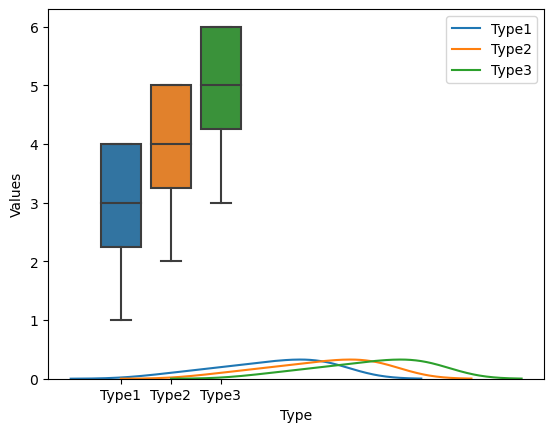

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, but it enhances the aesthetics of plots

# Sample data - replace this with your actual data
data = {
    'Type1': [1, 2, 2, 3, 3, 3, 4, 4, 4, 4],
    'Type2': [2, 3, 3, 4, 4, 4, 5, 5, 5, 5],
    'Type3': [3, 4, 4, 5, 5, 5, 6, 6, 6, 6]
}

# Create a DataFrame (assuming you're using pandas)
import pandas as pd
df = pd.DataFrame(data)

# Set up the figure and axis
fig, ax = plt.subplots()

# Box plot
sns.boxplot(data=df, ax=ax)

# Overlay density plots
for column in df.columns:
    sns.kdeplot(df[column], ax=ax, label=column)

# Set plot labels and legend
ax.set_xlabel('Type')
ax.set_ylabel('Values')
ax.legend()

# Show the plot
plt.show()